# Decision Tree Classifier for Classifying Music Emotions
---
## About the Dataset

For this experiment, our dataset contains 267 music samples that were labelled by 2 music experts and 151 samples labeled in the semi-supervised learning task. The dataset has a combination of high level and low level features. The high level features are tempo, arousal, and scale, which were all labelled by the music experts. The low level features were extracted from the music samples using the JAudio software.

---
## Libraries

We used the pandas and csv libraries to load the dataset, which is a csv file. Then we used numpy to manipulate the loaded dataset. We used the sci kit learn library for the decision tree algorithm.

In [1]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, norm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree.export import export_text
from sklearn.feature_selection import SelectFromModel, SelectKBest, VarianceThreshold, chi2, f_classif, mutual_info_classif
from XLB import *

import warnings
warnings.filterwarnings('ignore')

d:\program files\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


Here we load the data from the csv file and preprocess it by removing the header row and the filename column

After the initial preprocessing step, we separated the music features and the labelled emotion into the x_train and y_train arrays respectively

In [2]:
# extract data from files
x_train, y_train = extract_data("FinalTrainingSet.csv")
x_val, y_val = extract_data("Validation Set.csv")

# scale data values
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

# feature selection
num_features = 45
feat_sel = VarianceThreshold()
x_train = feat_sel.fit_transform(x_train)
# feat_sel_2 = SelectFromModel(estimator=DecisionTreeClassifier(random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=RandomForestClassifier(n_estimators=50,\
#                                              random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=LogisticRegression(random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=svm.LinearSVC(C=0.25, penalty="l1", dual=False,\
#                                     random_state=481516234))
# WINNER: 47.62% 0.45
feat_sel_2 = SelectKBest(mutual_info_classif,k=num_features)
x_train = feat_sel_2.fit_transform(x_train,y_train)
x_val = feat_sel_2.transform(feat_sel.transform(x_val))
# print("After Variance Threshold Feature Selection:",x_train.shape)

rand_seed = 3454132

oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)
x_smote, y_smote = oversampler.fit_resample(x_train,y_train)
print(x_smote.shape,y_smote.shape)

oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)
x_os, y_os = oversampler.fit_resample(x_train,y_train)
print(x_os.shape,y_os.shape)

(750, 45) (750,)
(750, 45) (750,)


In [3]:
#MOVING FEATURE HEADERS INTO A LIST
import csv

with open("FinalTrainingSet.csv") as f:
    reader = csv.reader(f)
    features = next(reader)

#Deleting everything except features from the dataset
features.remove("Row Labels")
features.remove("Theme")
features.remove("Theme(Numbered)")
print(len(features))
#Retained features after selection
selected_feats = feat_sel_2.get_support(True)

for ind, ft in sorted(enumerate(features), reverse=True): 
    if ind not in selected_feats:
        del features[ind]
  
#Printing modified list 
#print (features) 
#print (len(features))

324


In [4]:
themes = ["Calm","Cheerful","Bravery","Fearful","Love","Sadness"]
ovr_train = []
ovr_val = []
ovr_y_smote = []
ovr_y_os = []
for i in range(1,7):
    ovr_train.append(ovr_labels(y_train, i))
    ovr_val.append(ovr_labels(y_val,i))
    ovr_y_os.append(ovr_labels(y_os,i))
    ovr_y_smote.append(ovr_labels(y_smote,i))    

Here we perform different methods to deal with imbalanced datasets. We used the oversampling *Insert link to oversampling if needed* and SMOTE methodology *Insert link to SMOTE if needed*

Here we defined a function that will train the model and perform the hyperparameter search. x_train is the input data, y_train is the labels for the input data, and hp_search is the algorithm for hyperparameter search

This function trains the model, using the previously defined train_model function, and displays the confusion matrix of the model. 

The following cells are the experiments we ran with the default dataset, oversampled version, and SMOTE version using random search as the hyperparameter search algorithm

---
This cell instantiates the decison tree object and the hyperparameter search object.

In [5]:
# Decision Tree
random_search_iterations = 1000
n_splits = 5
rand_seed = 481516234

parameters = {
    'criterion':["gini", "entropy"], 
    'splitter':["best", "random"], 
    'max_depth':range(1, num_features + 1), 
    'min_samples_split': uniform(loc=0.00,scale=1.0),
    'min_samples_leaf': uniform(loc=0.0001,scale=0.4999)
}

# train classifier for SMOTE data
dt = tree.DecisionTreeClassifier(random_state=rand_seed)
rscv = RandomizedSearchCV(dt, parameters,cv=n_splits, random_state=rand_seed, n_iter=random_search_iterations,n_jobs=-1)

This model is trained using the default 

Best Score: 0.8653
Vanilla Train Accuracy: 86.2843%


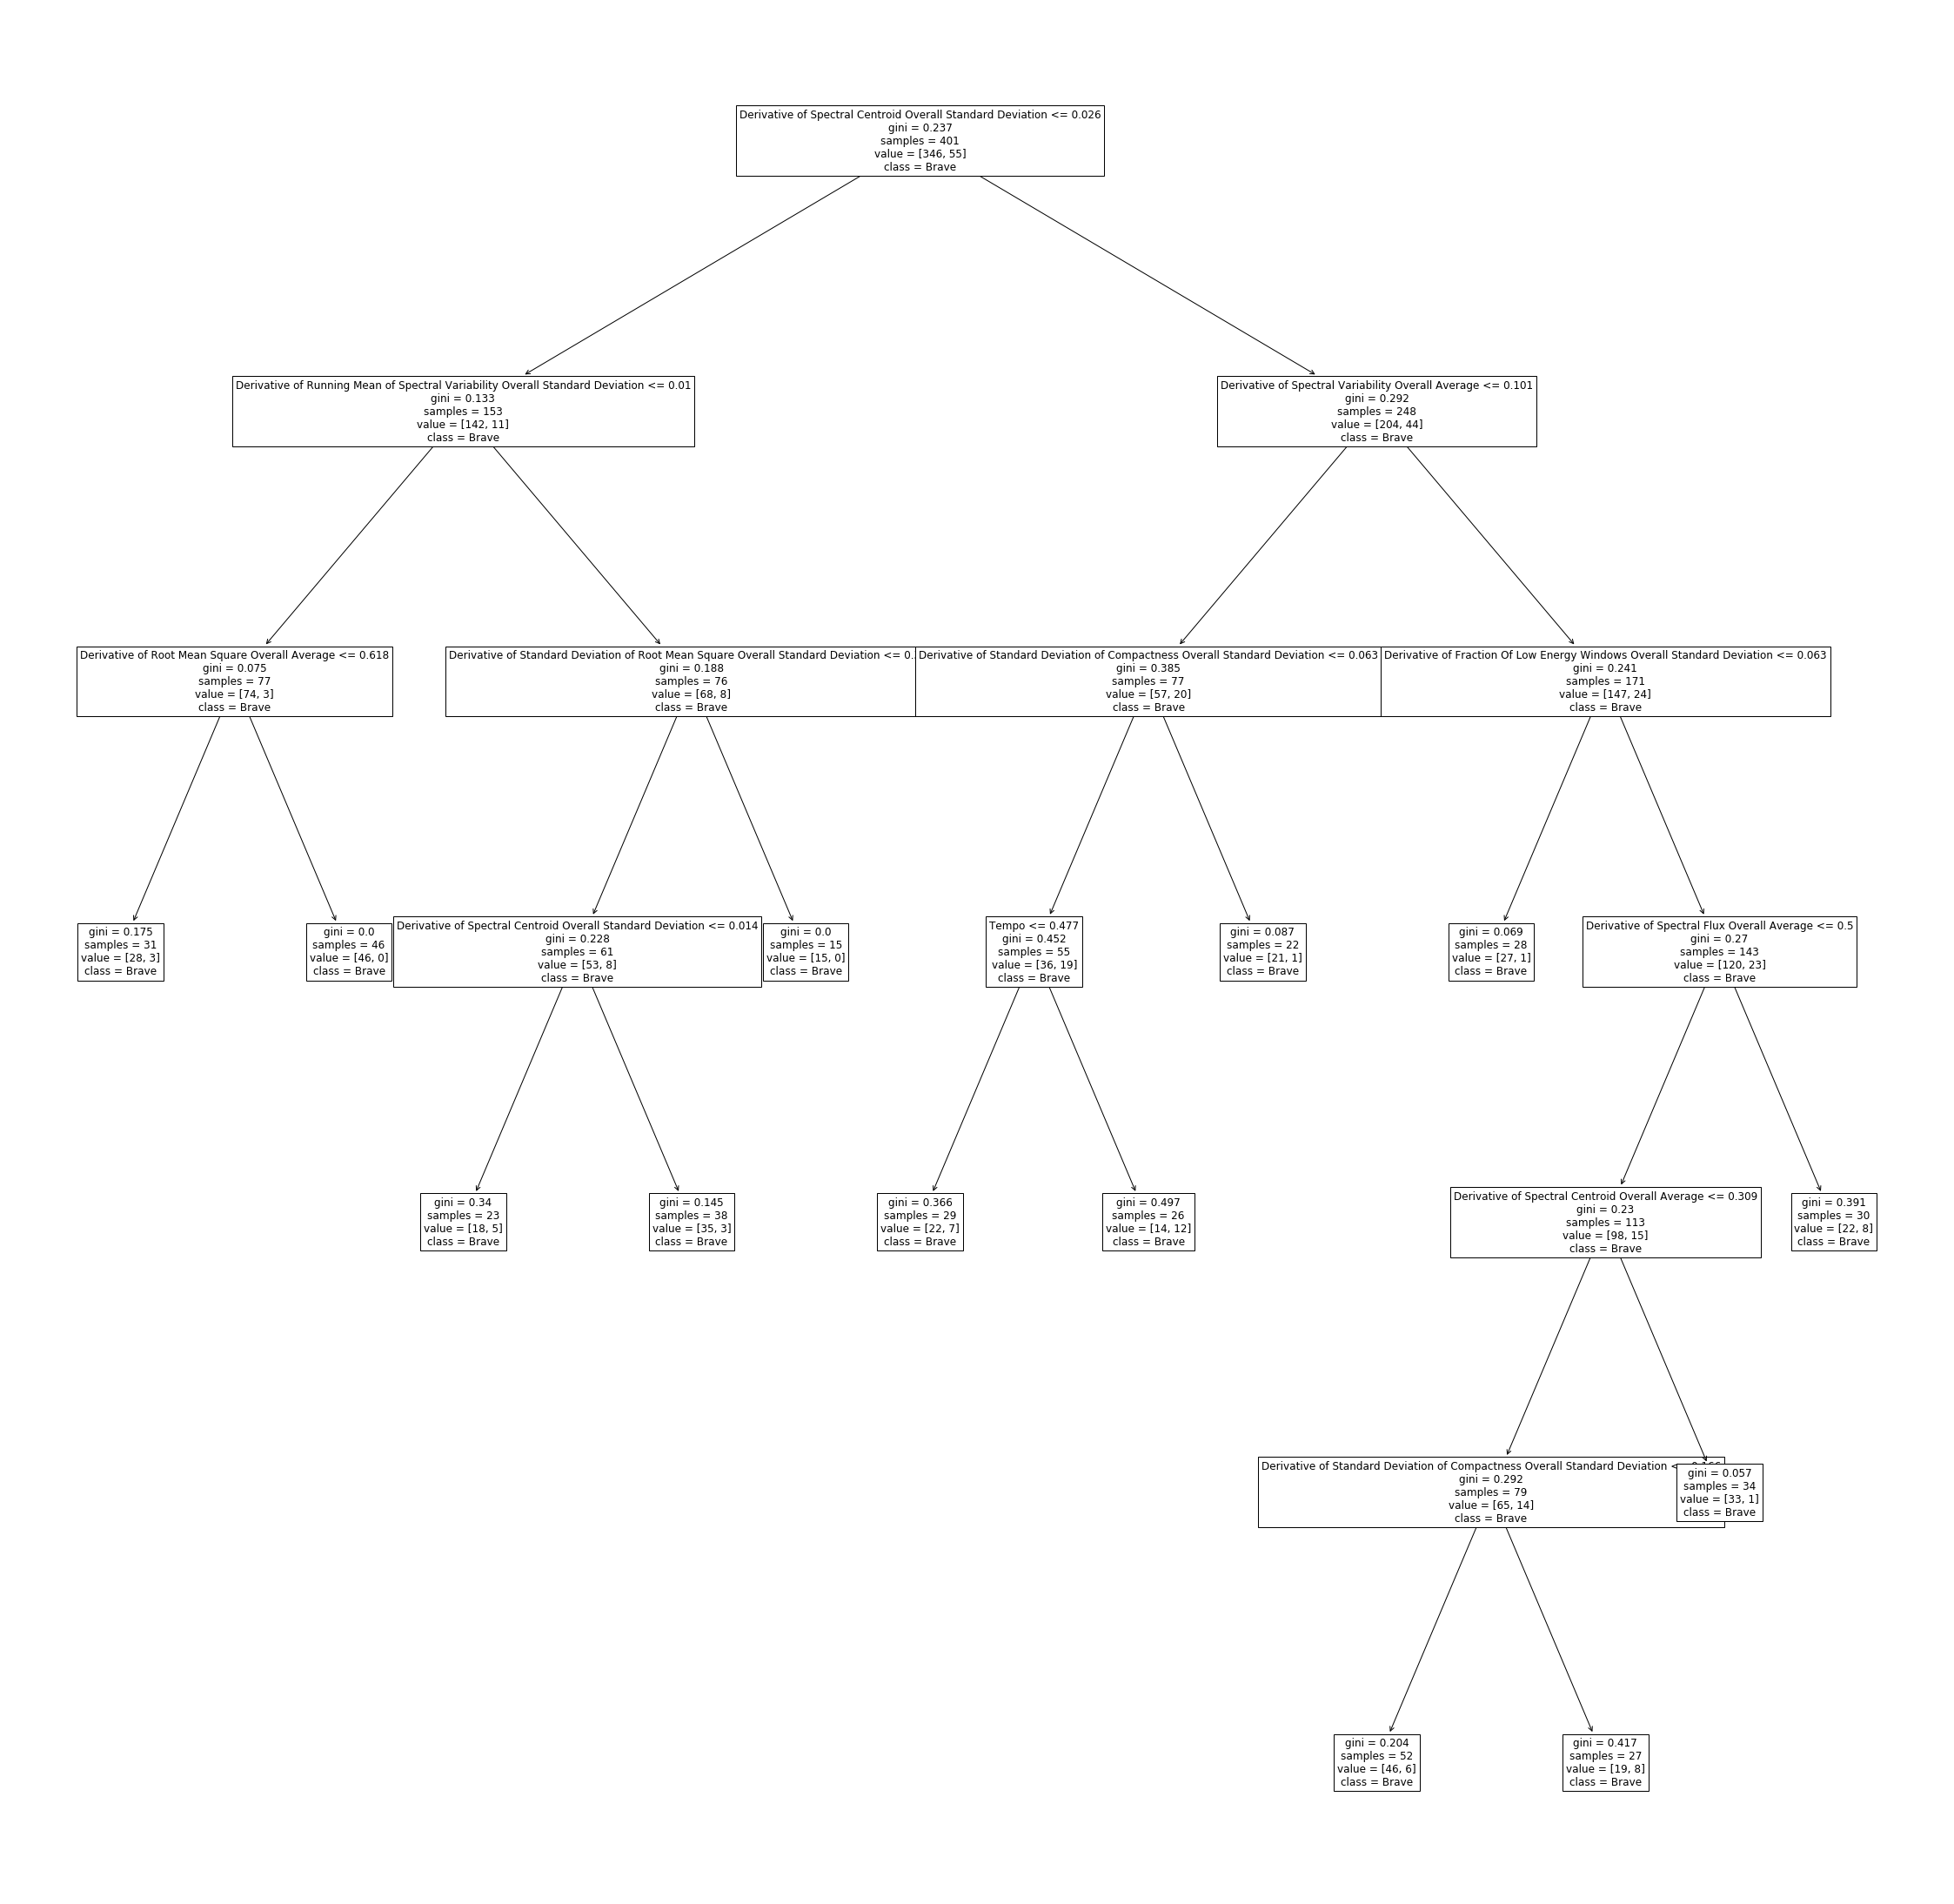

(85.71428571428571, 0.7912087912087911)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vanilla Validation Accuracy: 85.71%
Vanilla F1-score: 0.79


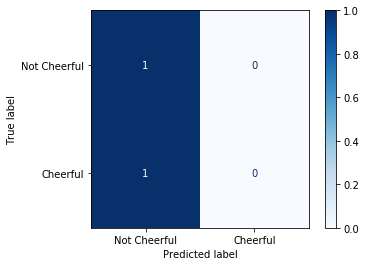

In [6]:
i = 1
print_res("Vanilla",x_train,ovr_train[i],rscv, themes[i], verbose = False)
disp_tree(rscv.best_estimator_,"FinalTrainingSet.csv")

test_res("Vanilla",x_val,ovr_val[i],rscv, themes[i])


In [13]:
#x = extract_rules(trfrom sklearn.tree import _treeee_to_text(rscv.best_estimator_, features))
#print(x)

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)
tree_to_code(rscv.best_estimator_, features)

def tree(Derivative of Running Mean of Fraction Of Low Energy Windows Overall Average, Derivative of Running Mean of Root Mean Square Overall Standard Deviation, Derivative of Running Mean of Spectral Variability Overall Average, Derivative of Running Mean of Spectral Variability Overall Standard Deviation, Derivative of Running Mean of Zero Crossings Overall Average, Derivative of Spectral Variability Overall Standard Deviation, Derivative of Standard Deviation of Fraction Of Low Energy Windows Overall Average, Derivative of Standard Deviation of Root Mean Square Overall Standard Deviation, Derivative of Standard Deviation of Spectral Flux Overall Average, Derivative of Standard Deviation of Spectral Variability Overall Average, Derivative of Standard Deviation of Spectral Variability Overall Standard Deviation, Derivative of Standard Deviation of Zero Crossings Overall Average, Fraction Of Low Energy Windows Overall Average, Magnitude Spectrum Overall Average, Running Mean of Spectra

AttributeError: 'sklearn.tree._tree.Tree' object has no attribute 'TREE_UNDEFINED'

Best Score: 0.8427
Random Oversampling Train Accuracy: 84.4000%


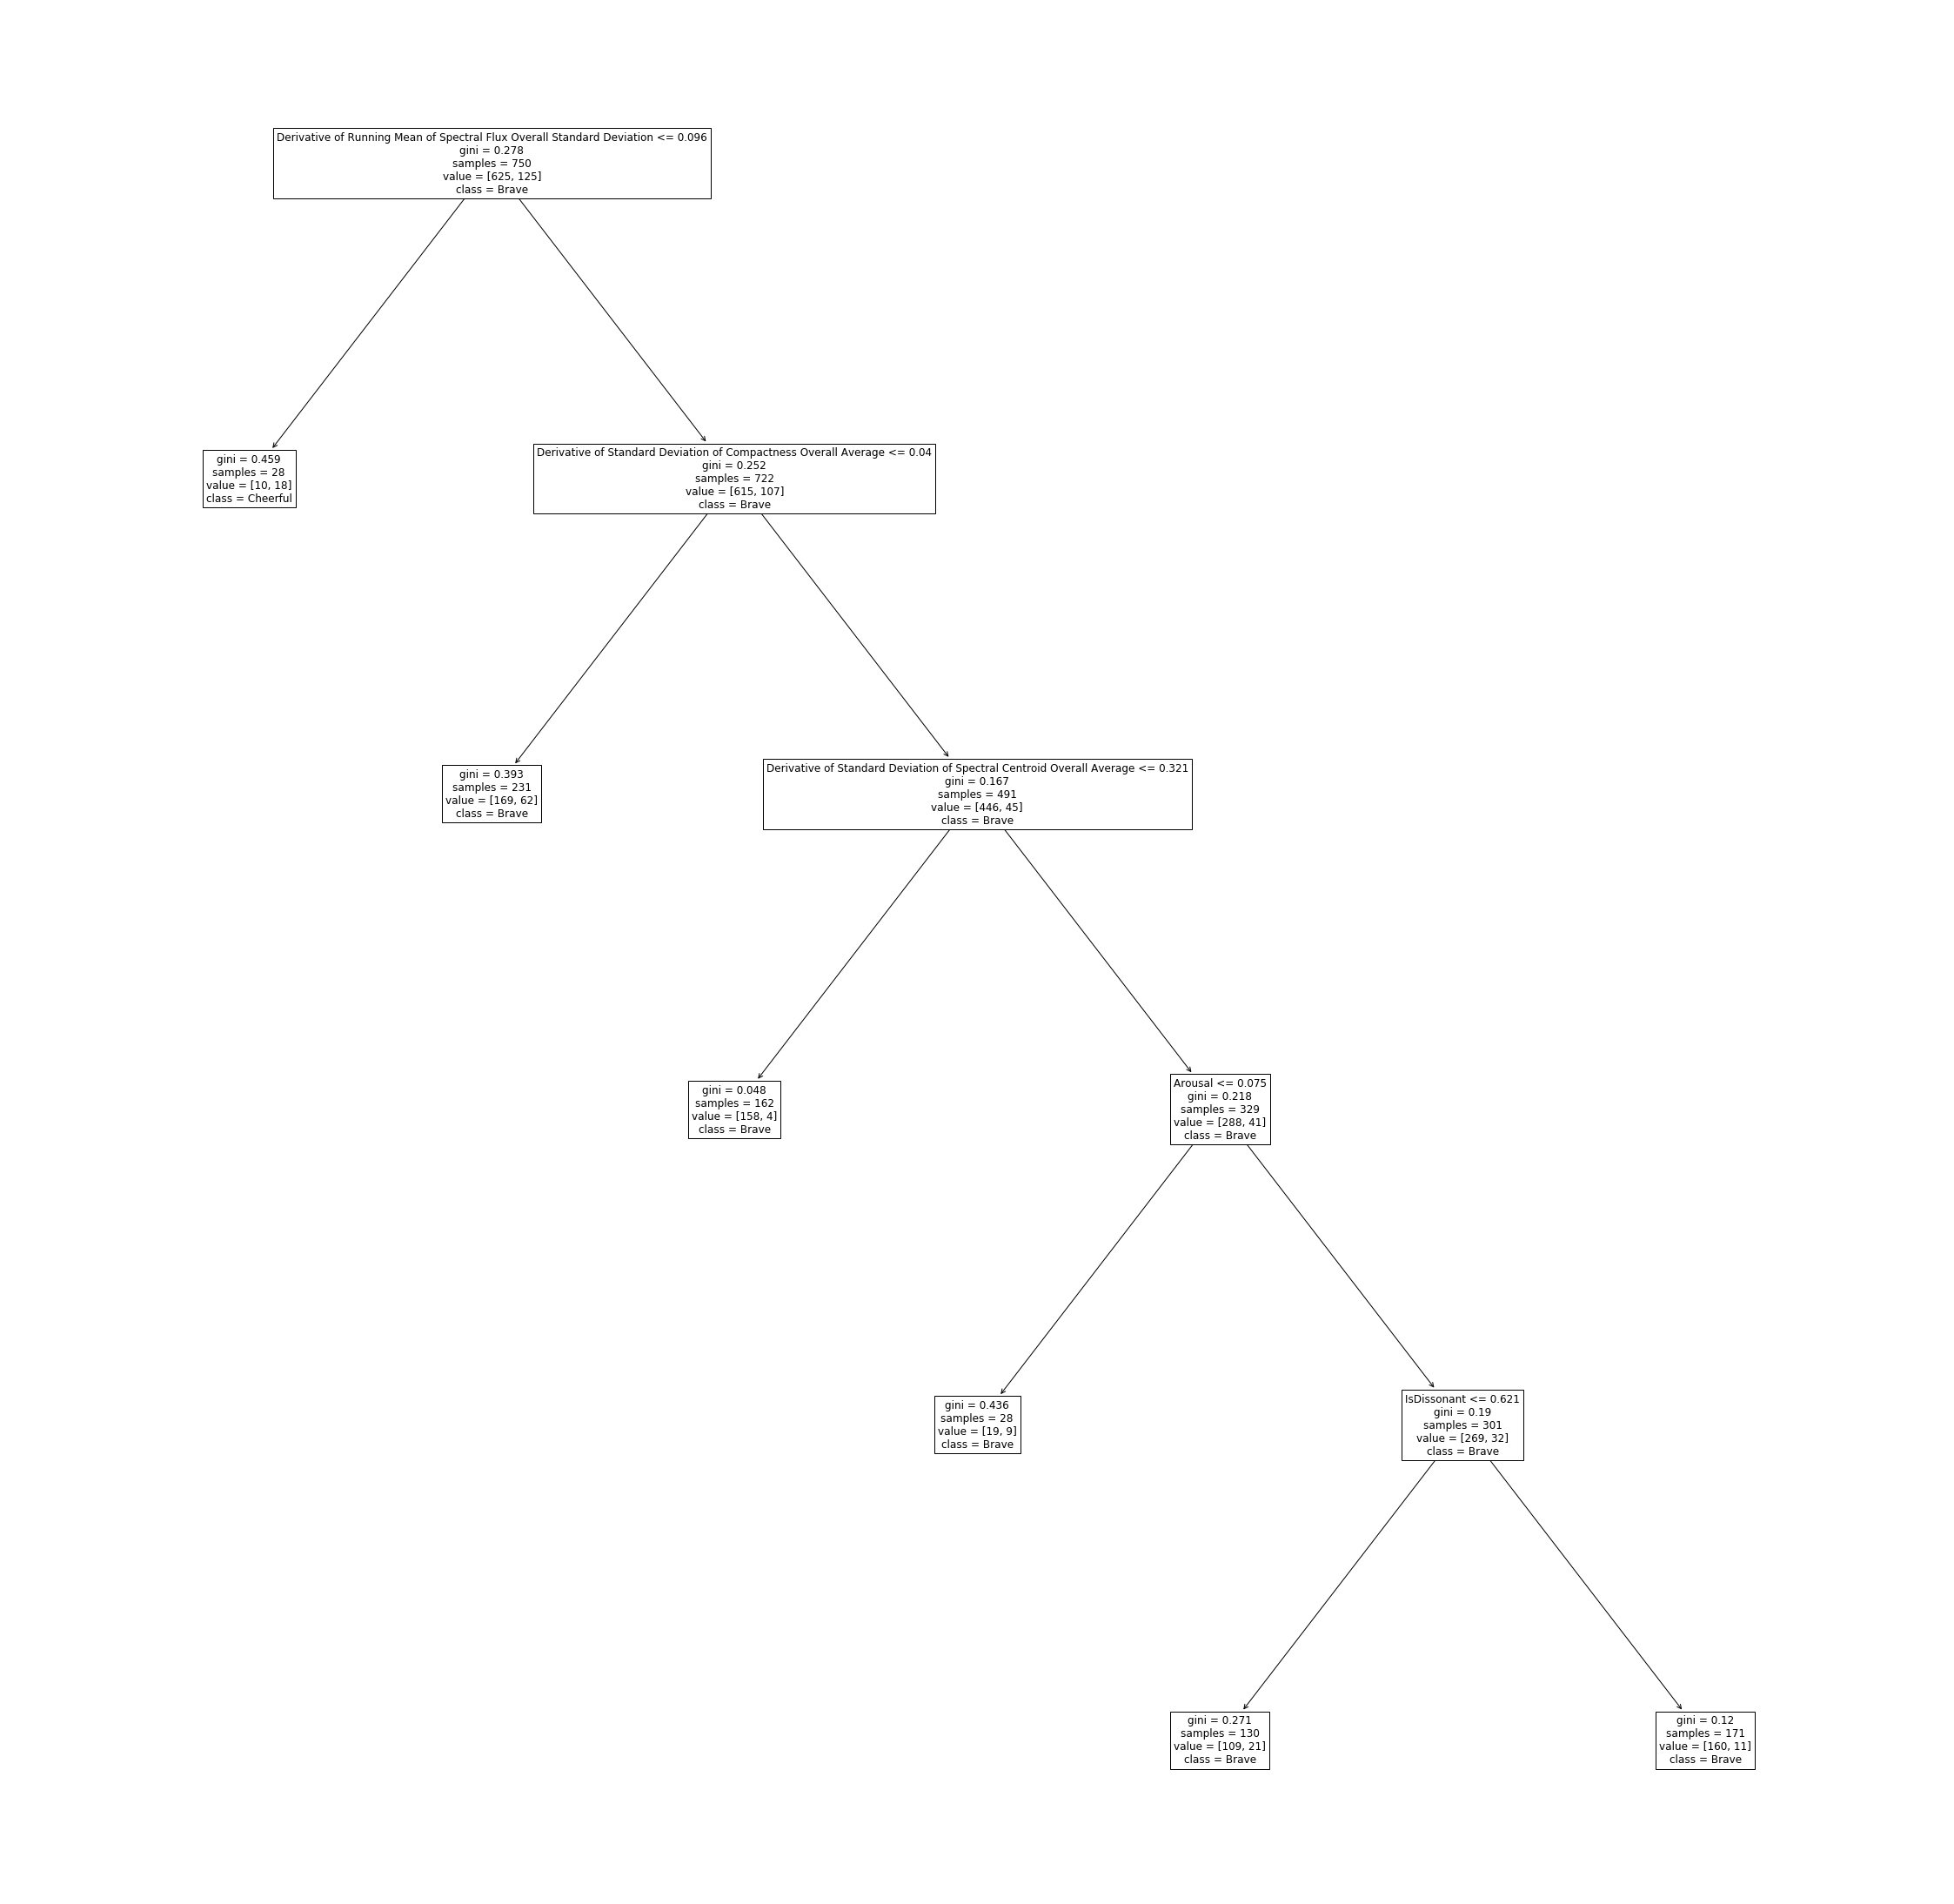

|--- Standard Deviation of Spectral Rolloff Point Overall Average <= 0.10
|   |--- class: 1
|--- Standard Deviation of Spectral Rolloff Point Overall Average >  0.10
|   |--- Derivative of Running Mean of Beat Sum Overall Average <= 0.04
|   |   |--- class: 0
|   |--- Derivative of Running Mean of Beat Sum Overall Average >  0.04
|   |   |--- Derivative of Running Mean of Partial Based Spectral Centroid Overall Average <= 0.32
|   |   |   |--- class: 0
|   |   |--- Derivative of Running Mean of Partial Based Spectral Centroid Overall Average >  0.32
|   |   |   |--- Derivative of Running Mean of Root Mean Square Overall Standard Deviation <= 0.08
|   |   |   |   |--- class: 0
|   |   |   |--- Derivative of Running Mean of Root Mean Square Overall Standard Deviation >  0.08
|   |   |   |   |--- Derivative of Running Mean of Zero Crossings Overall Average <= 0.62
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Derivative of Running Mean of Zero Crossings Overall Average >  0.62
| 

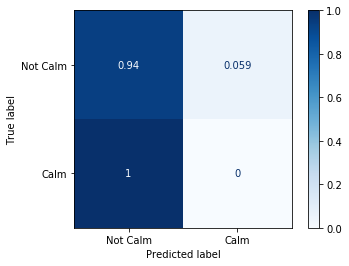

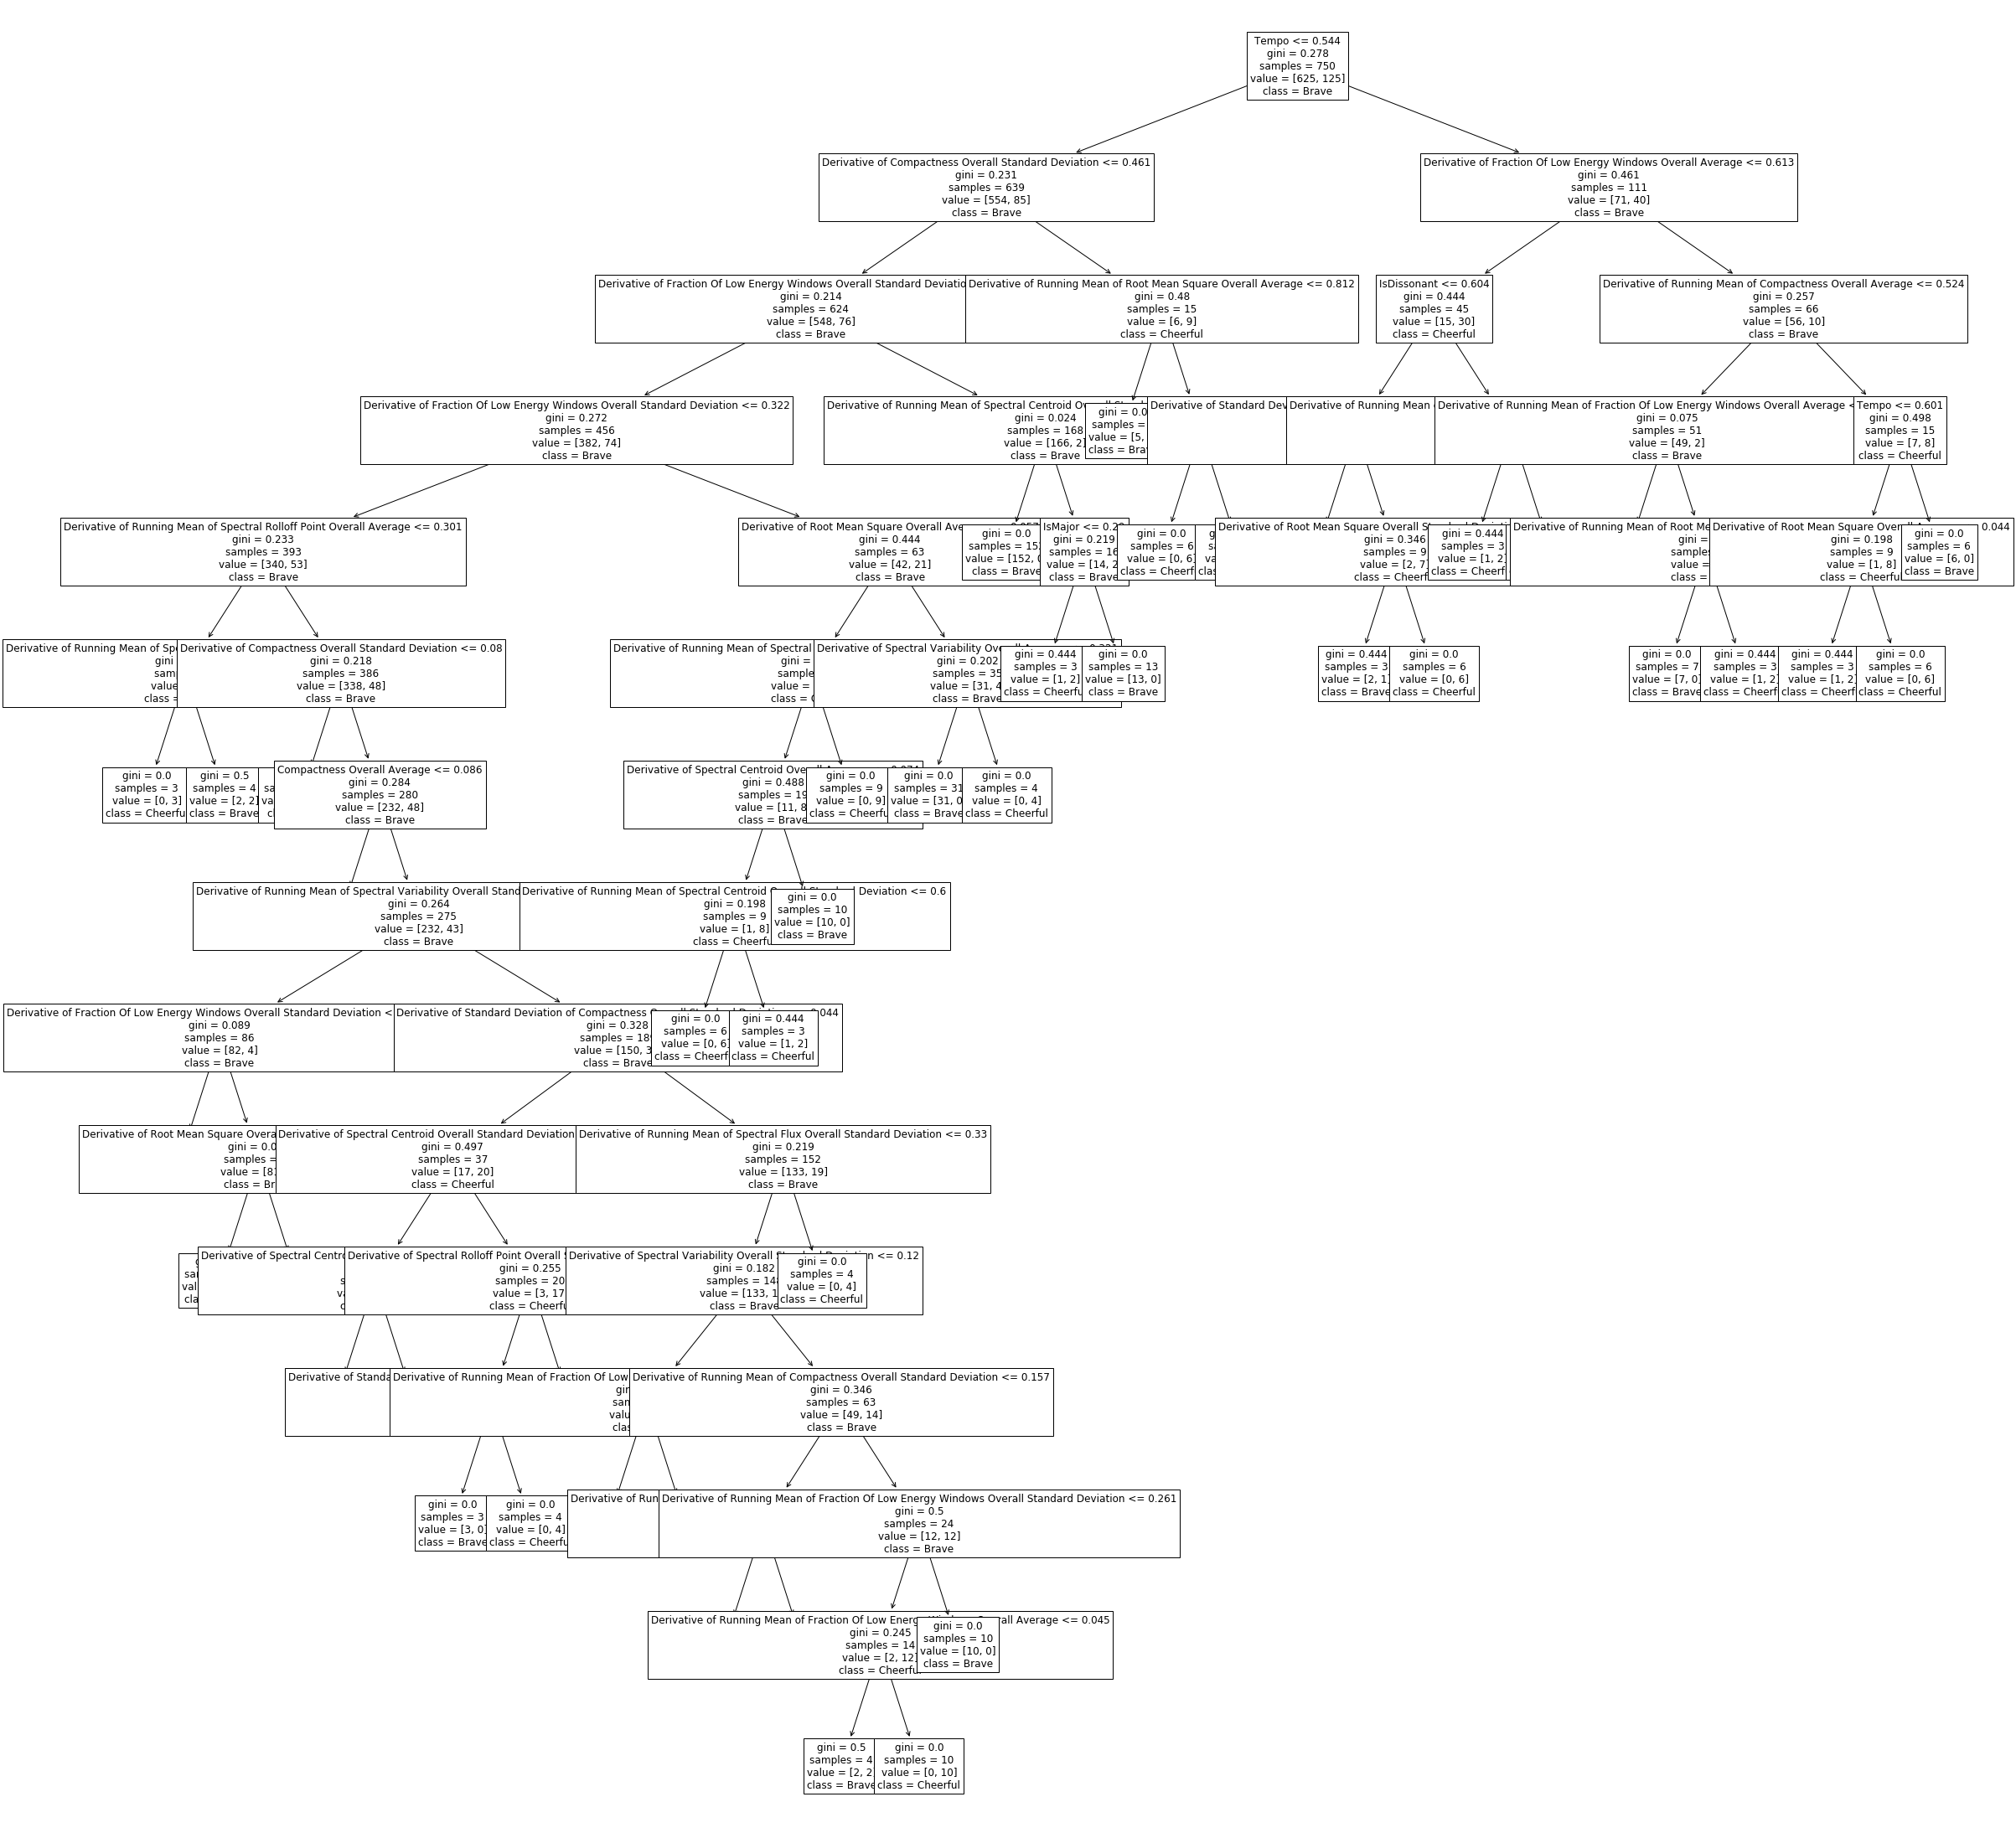

|--- Derivative of Running Mean of Fraction Of Low Energy Windows Overall Average <= 0.54
|   |--- Derivative of Standard Deviation of Spectral Variability Overall Standard Deviation <= 0.46
|   |   |--- Fraction Of Low Energy Windows Overall Average <= 0.36
|   |   |   |--- Fraction Of Low Energy Windows Overall Average <= 0.32
|   |   |   |   |--- Beat Histogram Overall Average <= 0.30
|   |   |   |   |   |--- Standard Deviation of Spectral Flux Overall Standard Deviation <= 0.03
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Standard Deviation of Spectral Flux Overall Standard Deviation >  0.03
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Beat Histogram Overall Average >  0.30
|   |   |   |   |   |--- Derivative of Standard Deviation of Spectral Variability Overall Standard Deviation <= 0.08
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Derivative of Standard Deviation of Spectral Variability Overall Standard Deviation >  0.08
|   |   |

Best Score: 0.8973
Random Oversampling Train Accuracy: 97.4667%


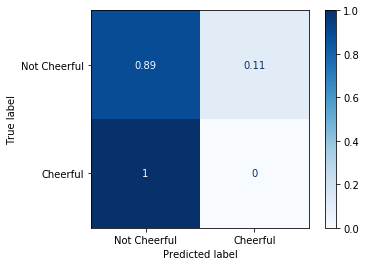

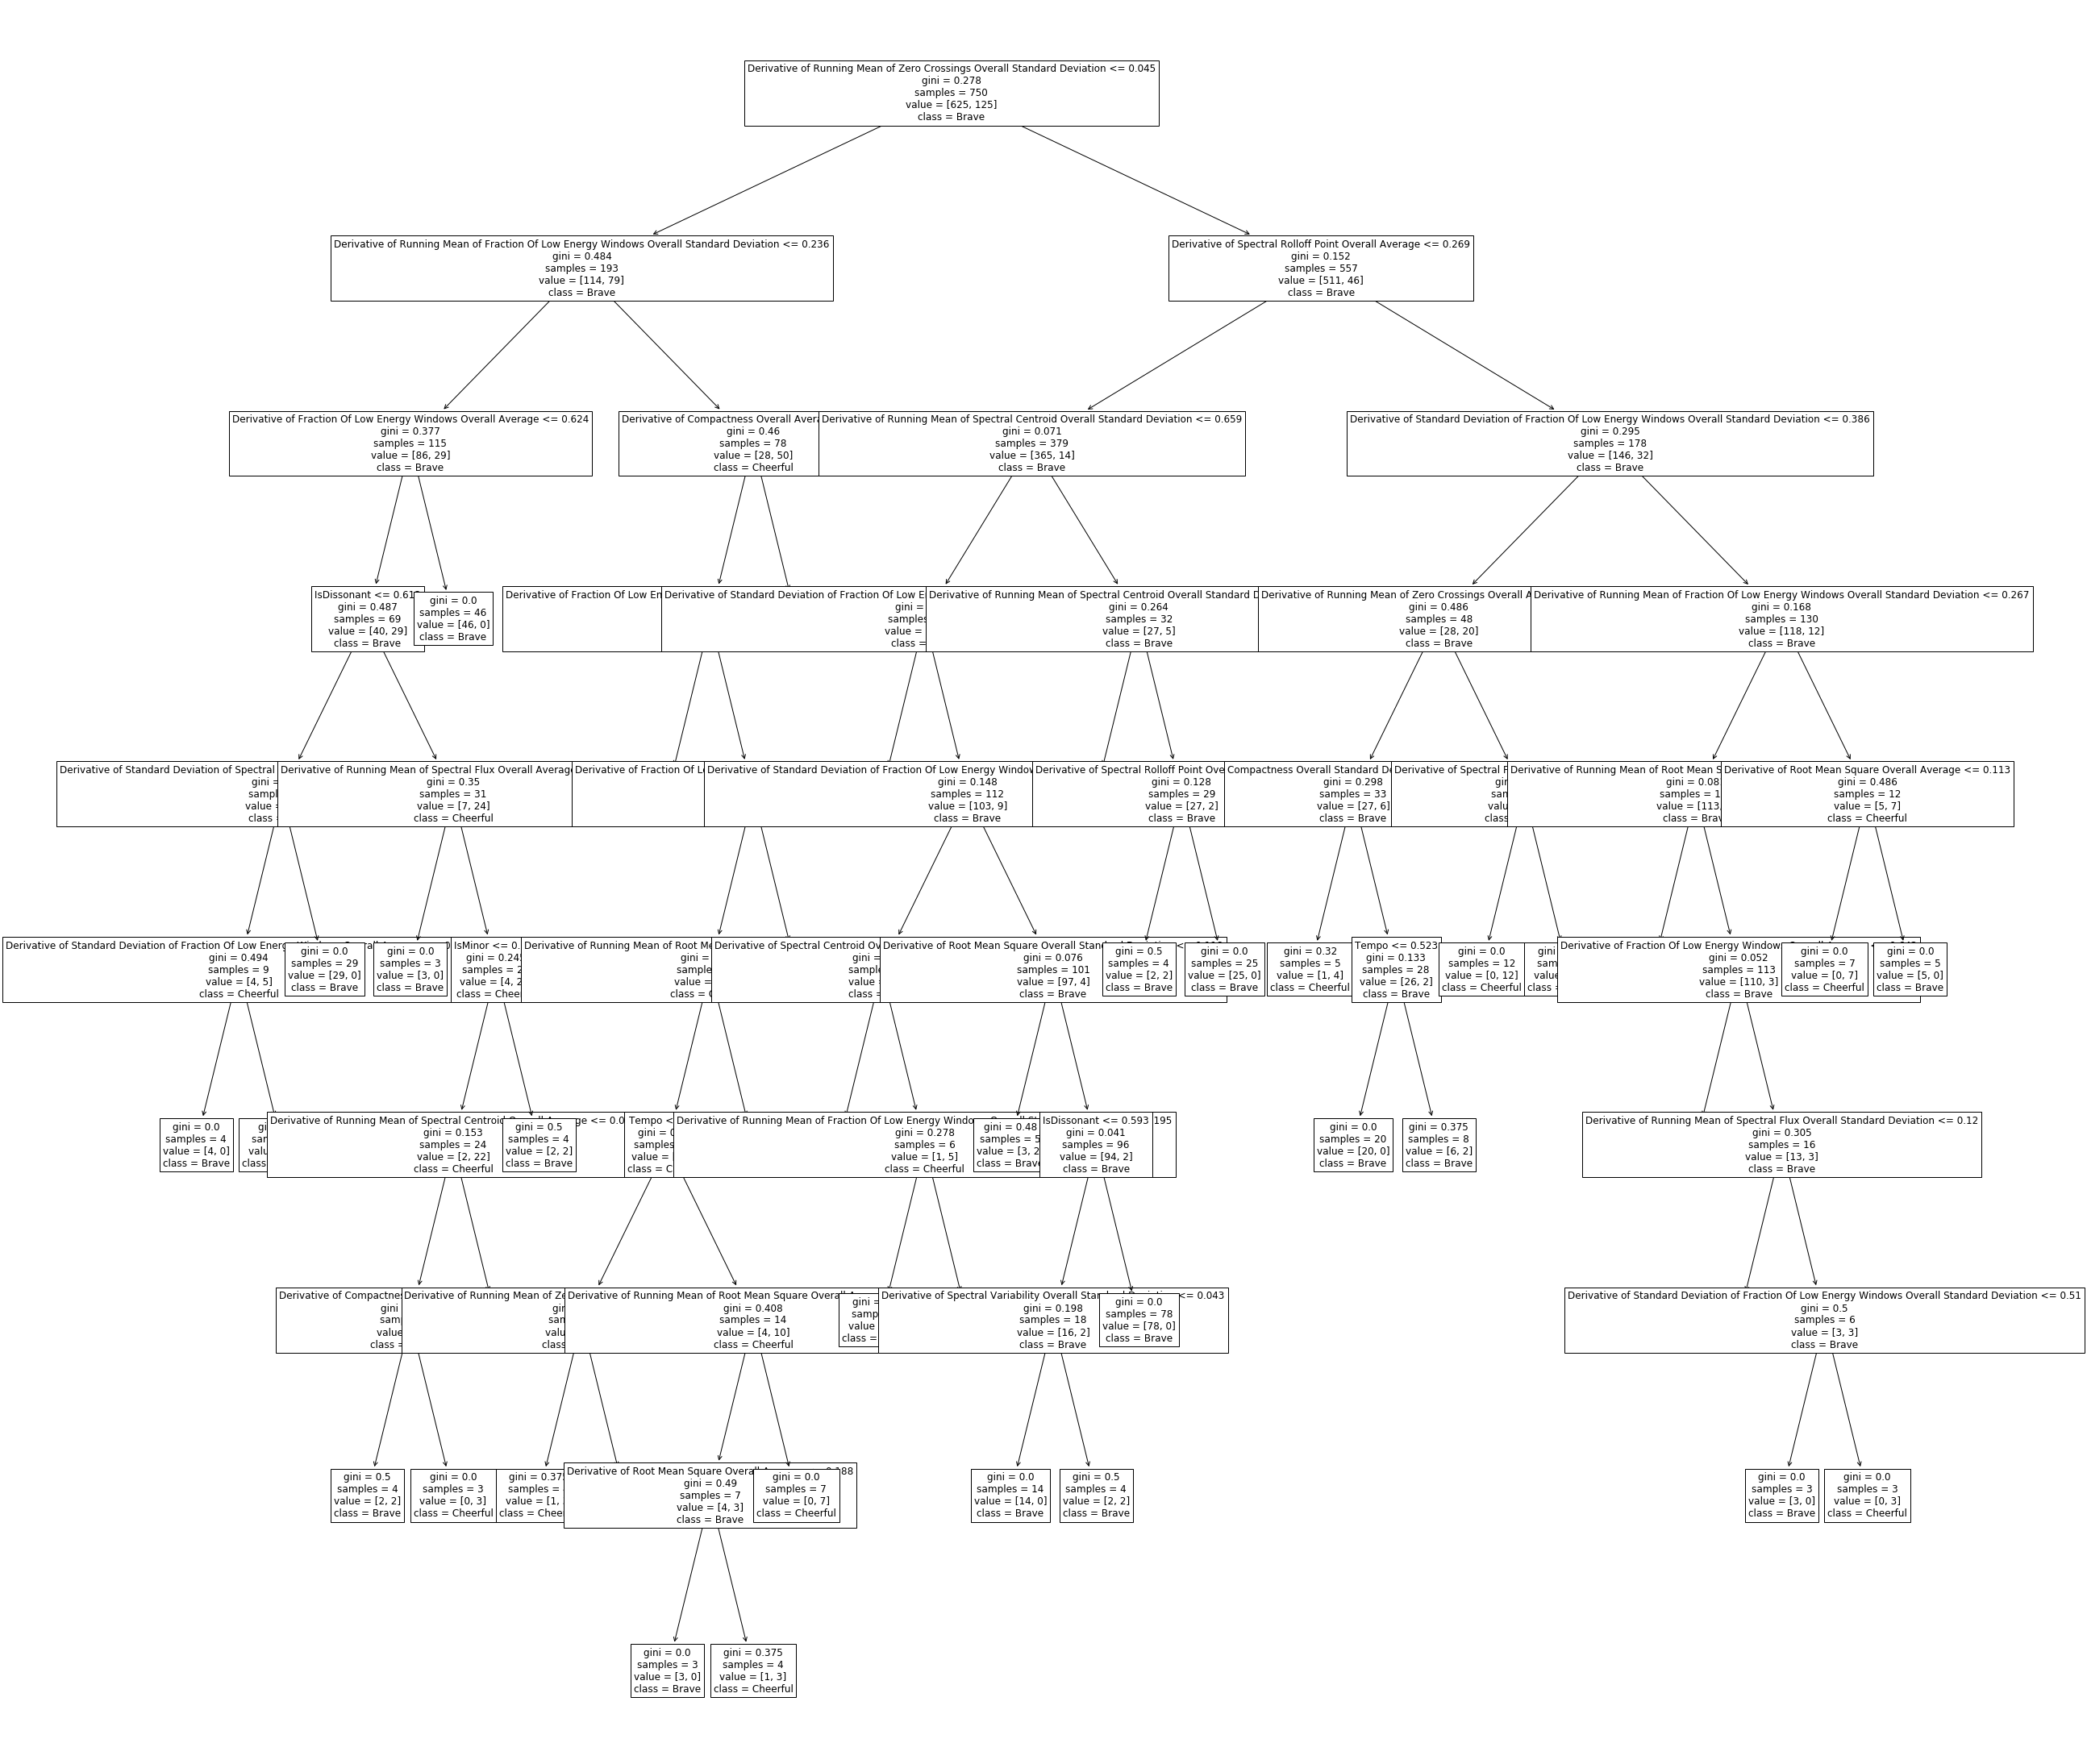

|--- Derivative of MFCC Overall Standard Deviation <= 0.04
|   |--- Spectral Rolloff Point Overall Standard Deviation <= 0.24
|   |   |--- Derivative of Standard Deviation of Zero Crossings Overall Average <= 0.62
|   |   |   |--- Derivative of Running Mean of Zero Crossings Overall Average <= 0.61
|   |   |   |   |--- Derivative of Running Mean of Partial Based Spectral Flux Overall Average <= 0.05
|   |   |   |   |   |--- Derivative of Running Mean of LPC Overall Average <= 0.10
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Derivative of Running Mean of LPC Overall Average >  0.10
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Derivative of Running Mean of Partial Based Spectral Flux Overall Average >  0.05
|   |   |   |   |   |--- class: 0
|   |   |   |--- Derivative of Running Mean of Zero Crossings Overall Average >  0.61
|   |   |   |   |--- Standard Deviation of Spectral Flux Overall Standard Deviation <= 0.09
|   |   |   |   |   |--- class: 0
|   | 

Best Score: 0.8600
Random Oversampling Train Accuracy: 97.0667%


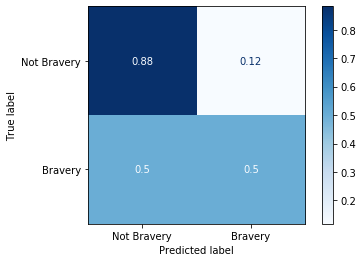

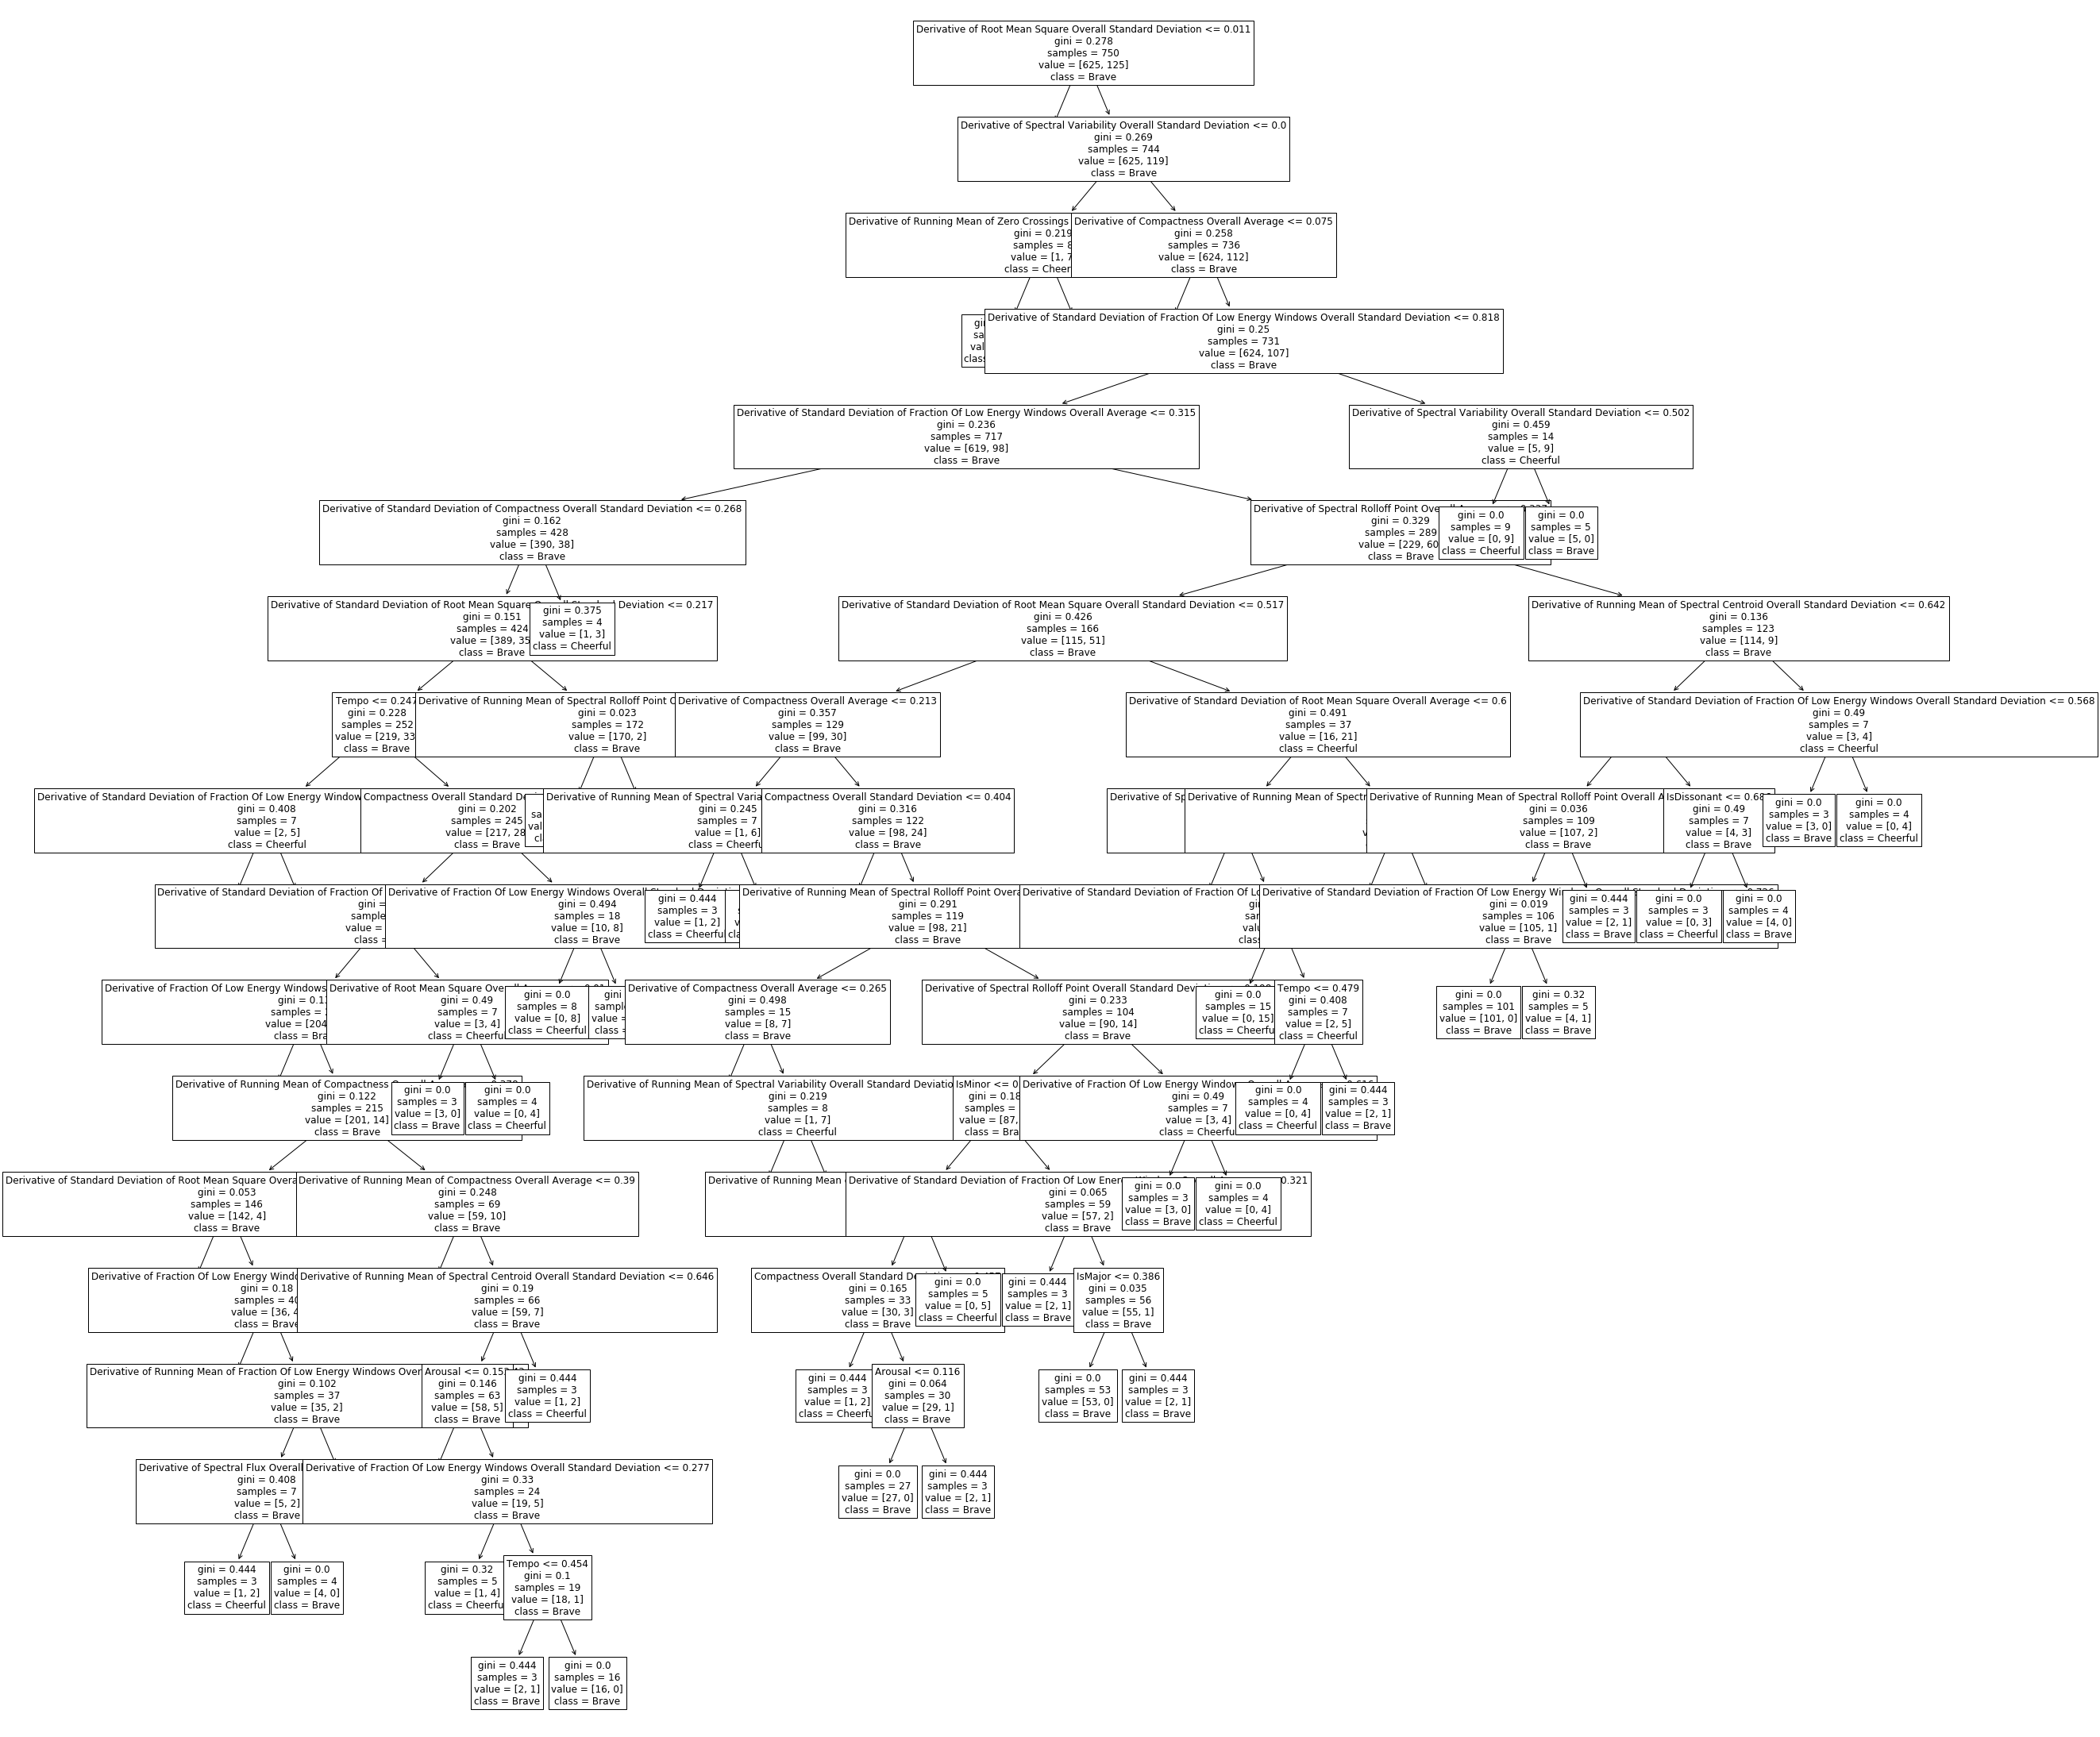

|--- Running Mean of Spectral Flux Overall Average <= 0.01
|   |--- class: 1
|--- Running Mean of Spectral Flux Overall Average >  0.01
|   |--- Derivative of Relative Difference Function Overall Standard Deviation <= 0.00
|   |   |--- Derivative of MFCC Overall Standard Deviation <= 0.00
|   |   |   |--- class: 1
|   |   |--- Derivative of MFCC Overall Standard Deviation >  0.00
|   |   |   |--- class: 1
|   |--- Derivative of Relative Difference Function Overall Standard Deviation >  0.00
|   |   |--- Derivative of Standard Deviation of Spectral Variability Overall Average <= 0.08
|   |   |   |--- class: 1
|   |   |--- Derivative of Standard Deviation of Spectral Variability Overall Average >  0.08
|   |   |   |--- Derivative of Running Mean of LPC Overall Standard Deviation <= 0.82
|   |   |   |   |--- Derivative of Running Mean of LPC Overall Average <= 0.32
|   |   |   |   |   |--- Derivative of Running Mean of Beat Sum Overall Standard Deviation <= 0.27
|   |   |   |   |   |   |-

Best Score: 0.9640
Random Oversampling Train Accuracy: 99.4667%


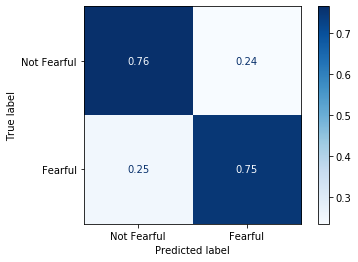

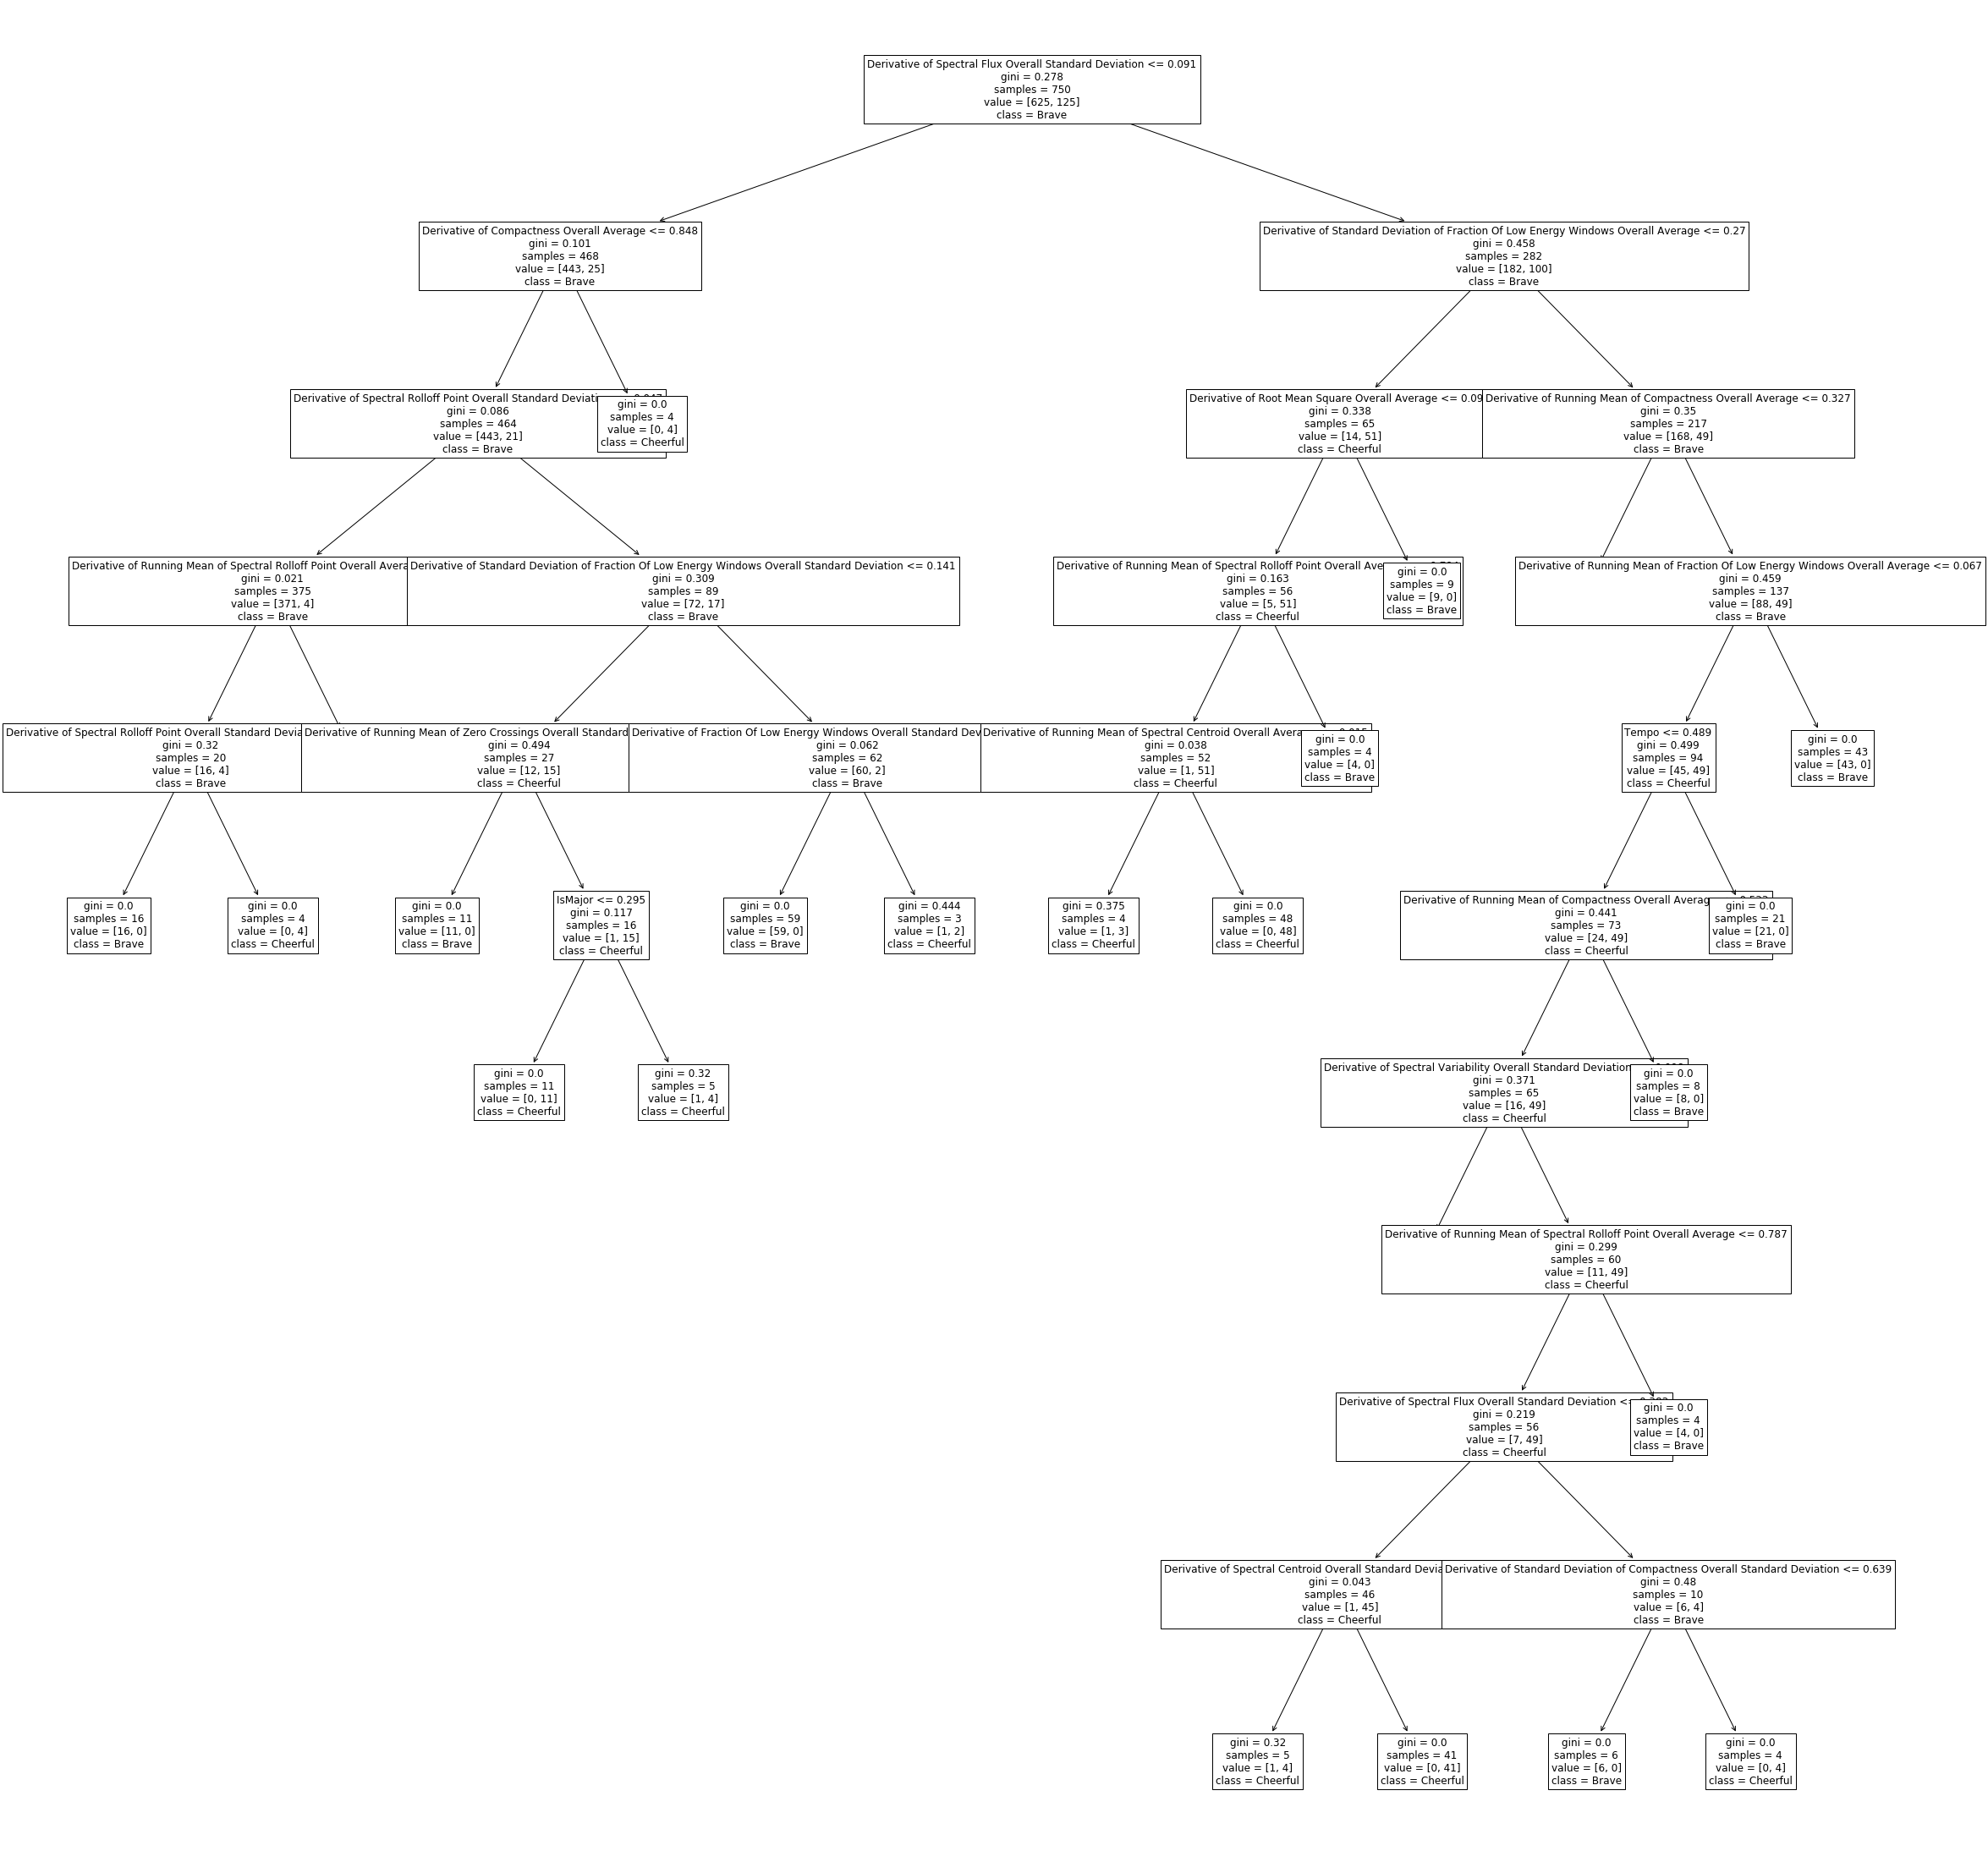

|--- Derivative of Partial Based Spectral Flux Overall Standard Deviation <= 0.09
|   |--- Derivative of Standard Deviation of Spectral Variability Overall Average <= 0.85
|   |   |--- Derivative of Peak Based Spectral Smoothness Overall Standard Deviation <= 0.05
|   |   |   |--- Beat Histogram Overall Average <= 0.19
|   |   |   |   |--- Derivative of Peak Based Spectral Smoothness Overall Standard Deviation <= 0.02
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Derivative of Peak Based Spectral Smoothness Overall Standard Deviation >  0.02
|   |   |   |   |   |--- class: 1
|   |   |   |--- Beat Histogram Overall Average >  0.19
|   |   |   |   |--- class: 0
|   |   |--- Derivative of Peak Based Spectral Smoothness Overall Standard Deviation >  0.05
|   |   |   |--- Derivative of Running Mean of LPC Overall Standard Deviation <= 0.14
|   |   |   |   |--- Derivative of MFCC Overall Standard Deviation <= 0.09
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Derivative of 

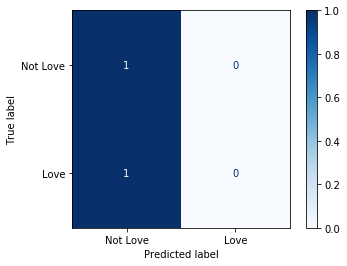

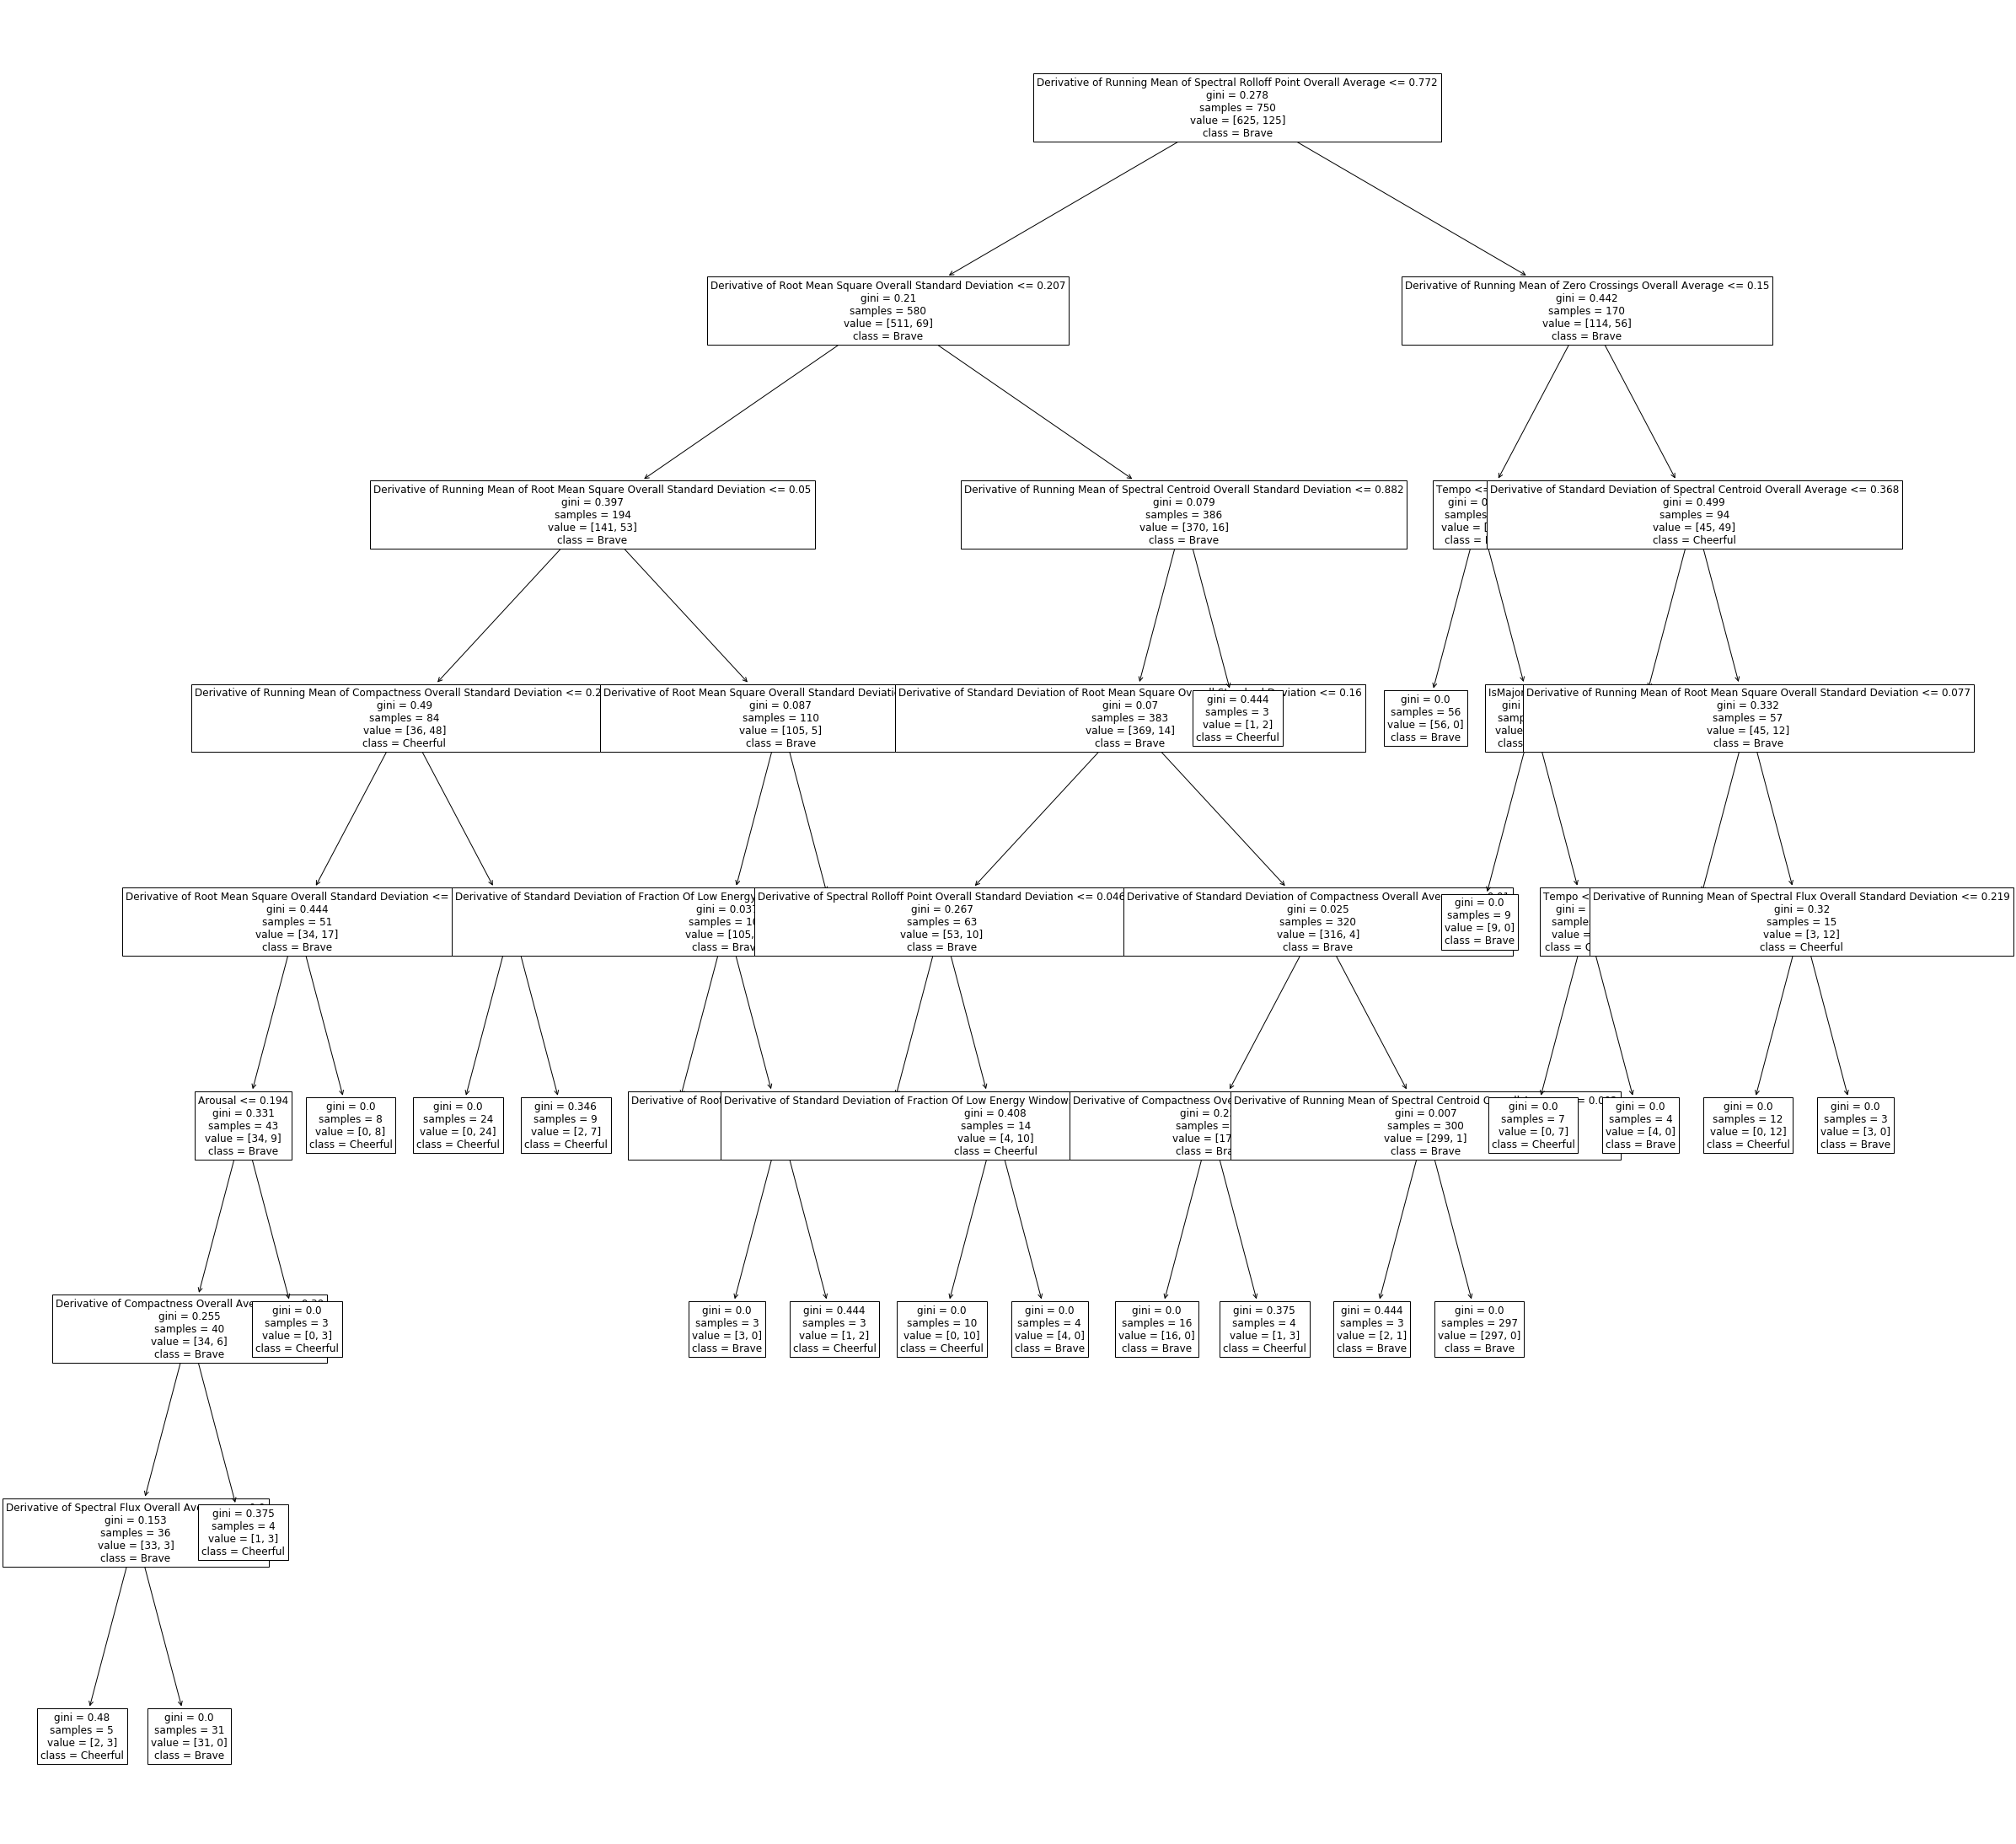

|--- Beat Histogram Overall Average <= 0.77
|   |--- Running Mean of Spectral Flux Overall Average <= 0.21
|   |   |--- Standard Deviation of Spectral Centroid Overall Average <= 0.05
|   |   |   |--- Running Mean of Spectral Rolloff Point Overall Average <= 0.24
|   |   |   |   |--- Running Mean of Spectral Flux Overall Average <= 0.20
|   |   |   |   |   |--- Derivative of Running Mean of Root Mean Square Overall Standard Deviation <= 0.19
|   |   |   |   |   |   |--- Derivative of Standard Deviation of Spectral Variability Overall Average <= 0.39
|   |   |   |   |   |   |   |--- Derivative of Partial Based Spectral Flux Overall Average <= 0.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Derivative of Partial Based Spectral Flux Overall Average >  0.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Derivative of Standard Deviation of Spectral Variability Overall Average >  0.39
|   |   |   |   |   |   |   |--- class: 1
| 

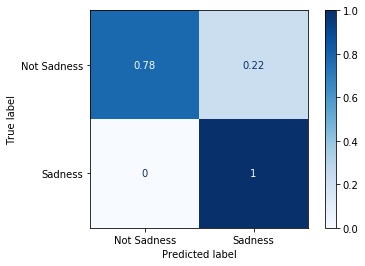

In [16]:
for i in range(0,6):
    if(i > 0):
        print()
    print_res("Random Oversampling",x_os,ovr_y_os[i],rscv,themes[i], verbose = False)
    disp_tree(rscv.best_estimator_,"FinalTrainingSet.csv")
    disp_tree_text(rscv.best_estimator_, features)
    test_res("Random Oversampling",x_val,ovr_val[i],rscv,themes[i])

Best Score: 0.8387
criterion => gini
max_depth => 25
min_samples_leaf => 0.01449781982176273
min_samples_split => 0.6433876573220169
splitter => random
Splits: 5
SMOTE Train Accuracy: 84.0000%


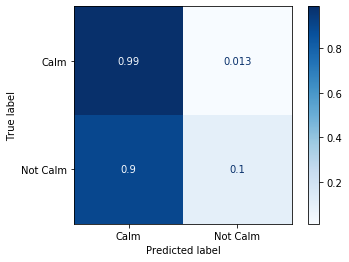

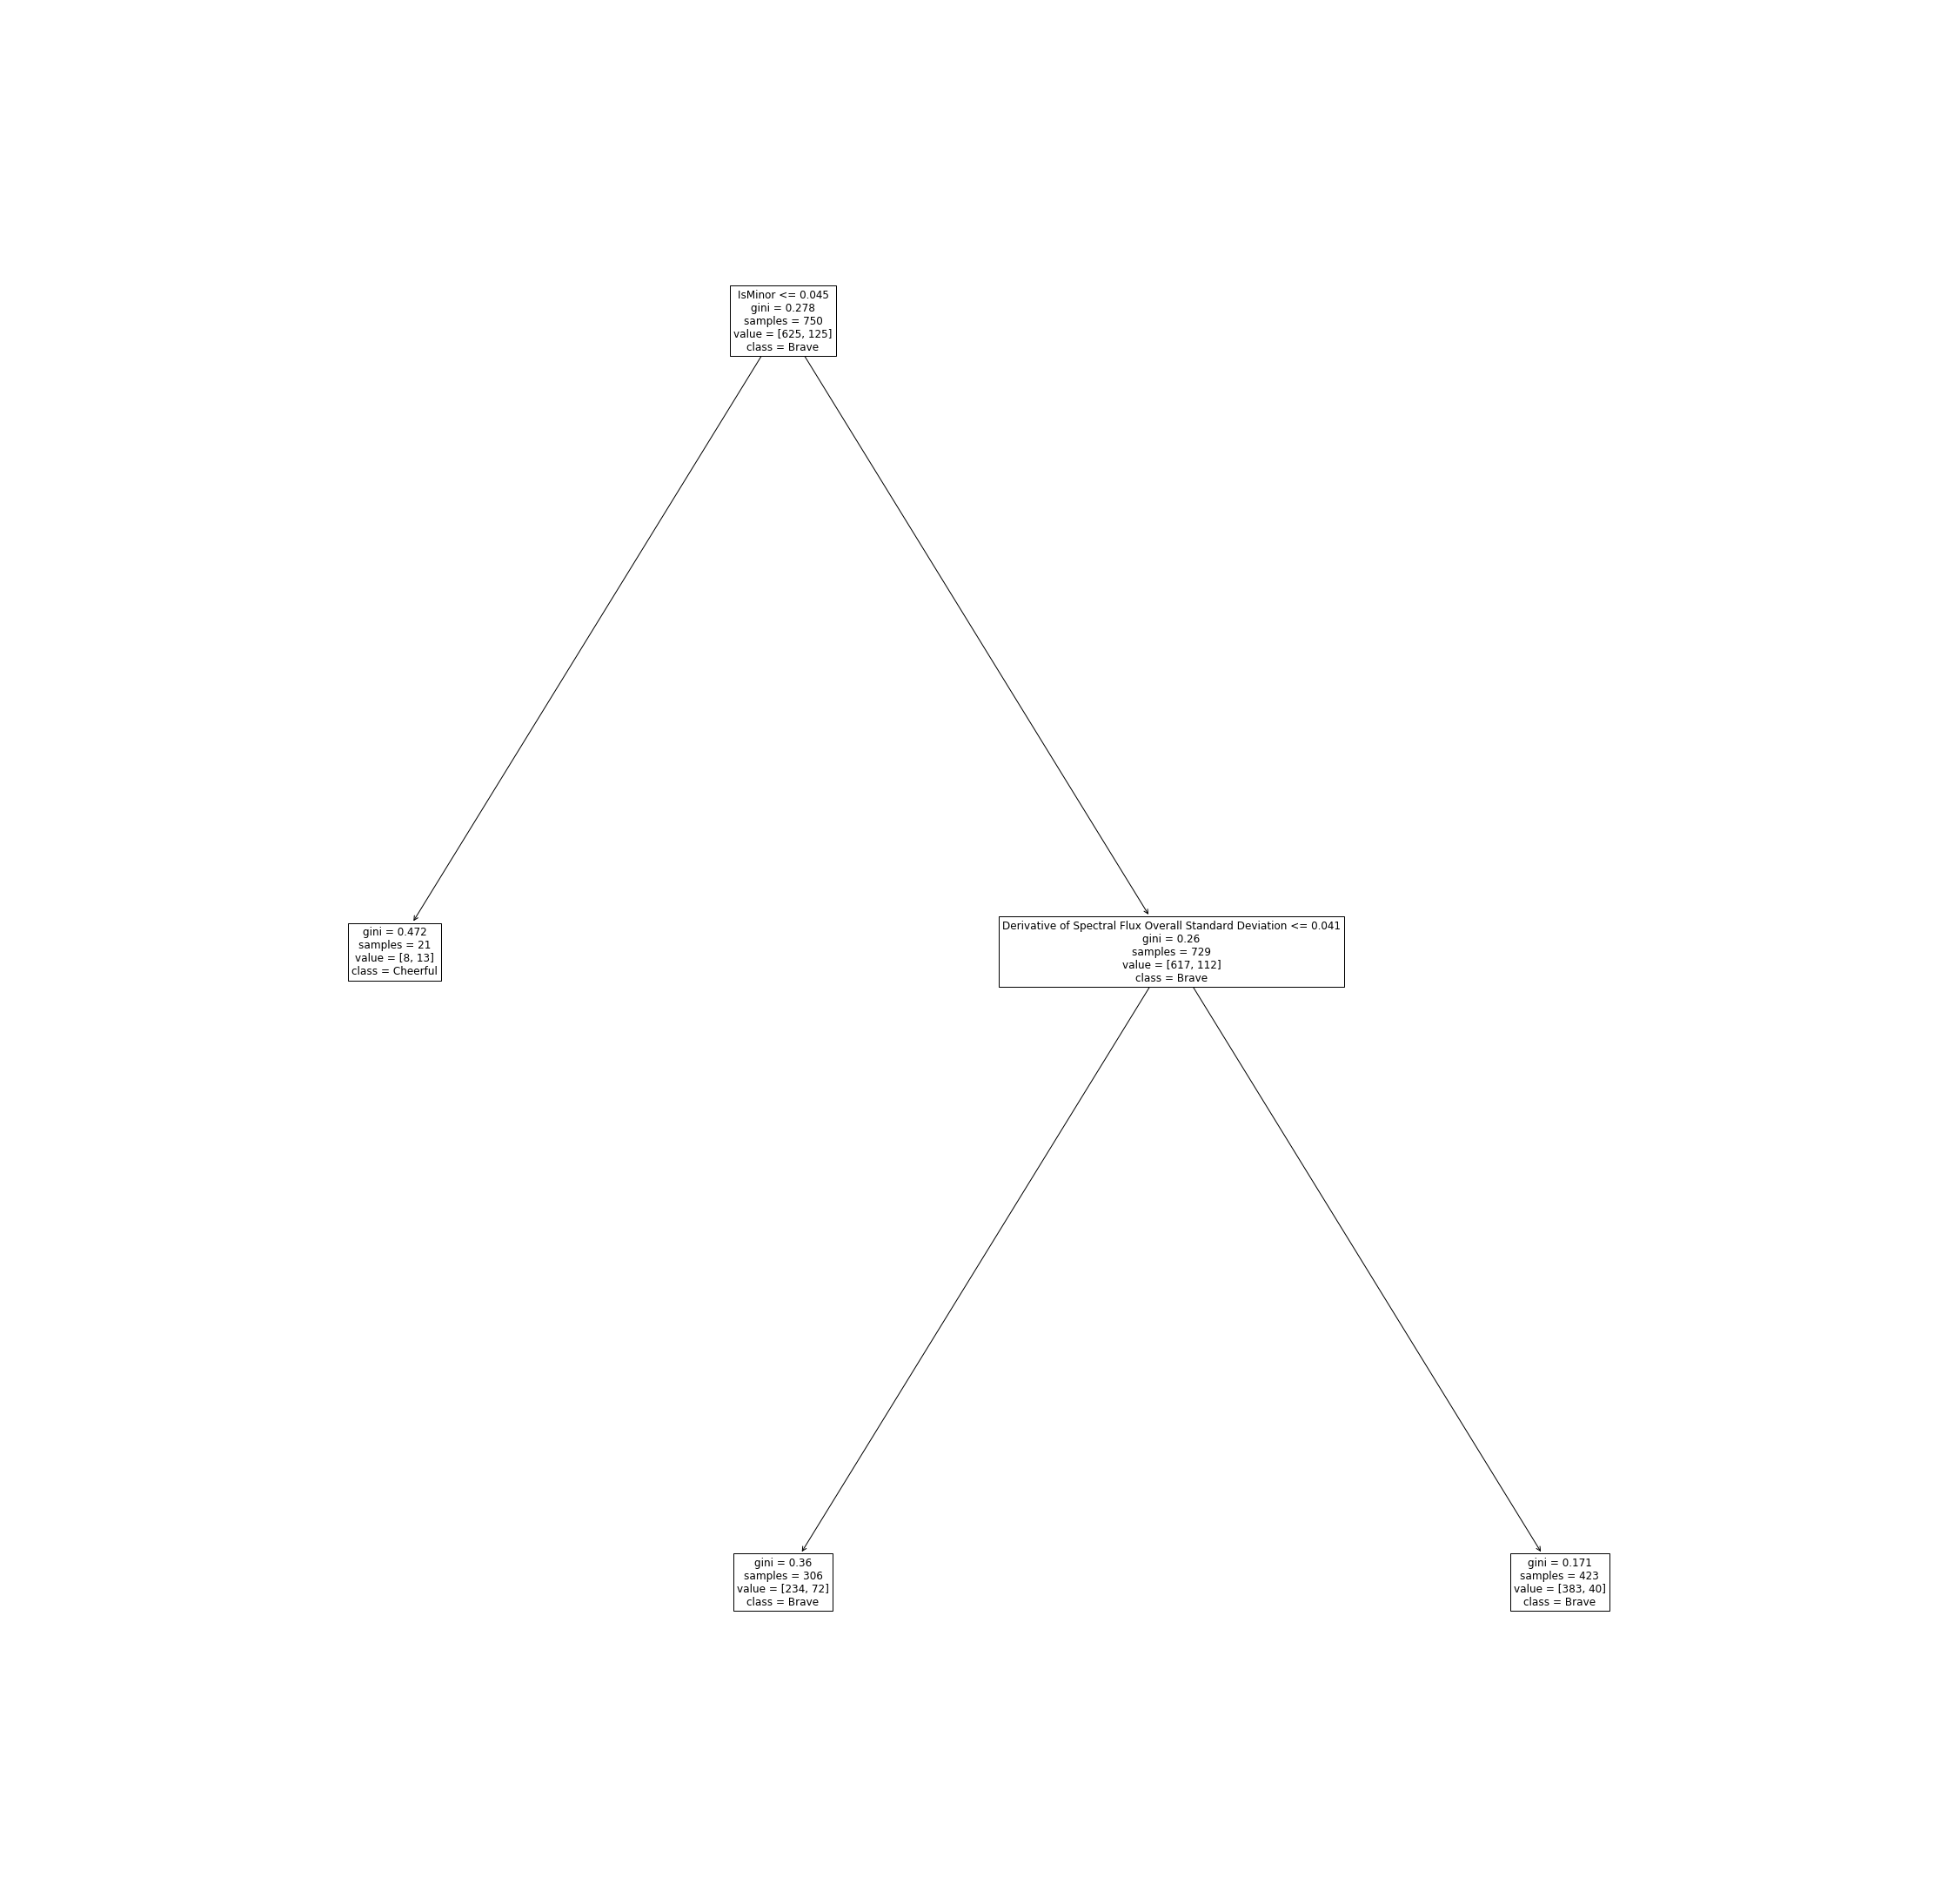

Derivative_of_Running_Mean_of_Spectral_Variability_Overall_Standard_Deviation <= 0.04 and Themes == 1 Confidence: 0.3117206982543641
Derivative_of_Running_Mean_of_Spectral_Variability_Overall_Standard_Deviation > 0.04 and Derivative_of_Partial_Based_Spectral_Flux_Overall_Standard_Deviation <= 0.04 and not Themes == 1 Confidence: 0
Derivative_of_Partial_Based_Spectral_Flux_Overall_Standard_Deviation > 0.04 and not Themes == 1 Confidence: 0.6882793017456359
Average Confidence: 0.3333333333333333
Derivative_of_Running_Mean_of_Spectral_Variability_Overall_Standard_Deviation <= 0.04 and Themes == 1 Lift: 0.4528985507246377
Derivative_of_Running_Mean_of_Spectral_Variability_Overall_Standard_Deviation > 0.04 and Derivative_of_Partial_Based_Spectral_Flux_Overall_Standard_Deviation <= 0.04 and not Themes == 1 Lift: 0.0
Derivative_of_Partial_Based_Spectral_Flux_Overall_Standard_Deviation > 0.04 and not Themes == 1 Lift: 2.2079999999999997
Average Lift: 0.8869661835748791
[0 0 0 0 0 0 0 0 0 0 0 0

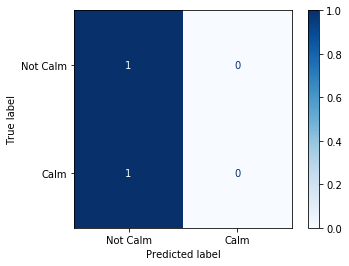

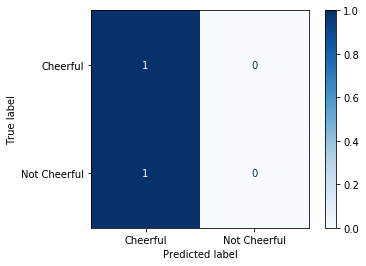

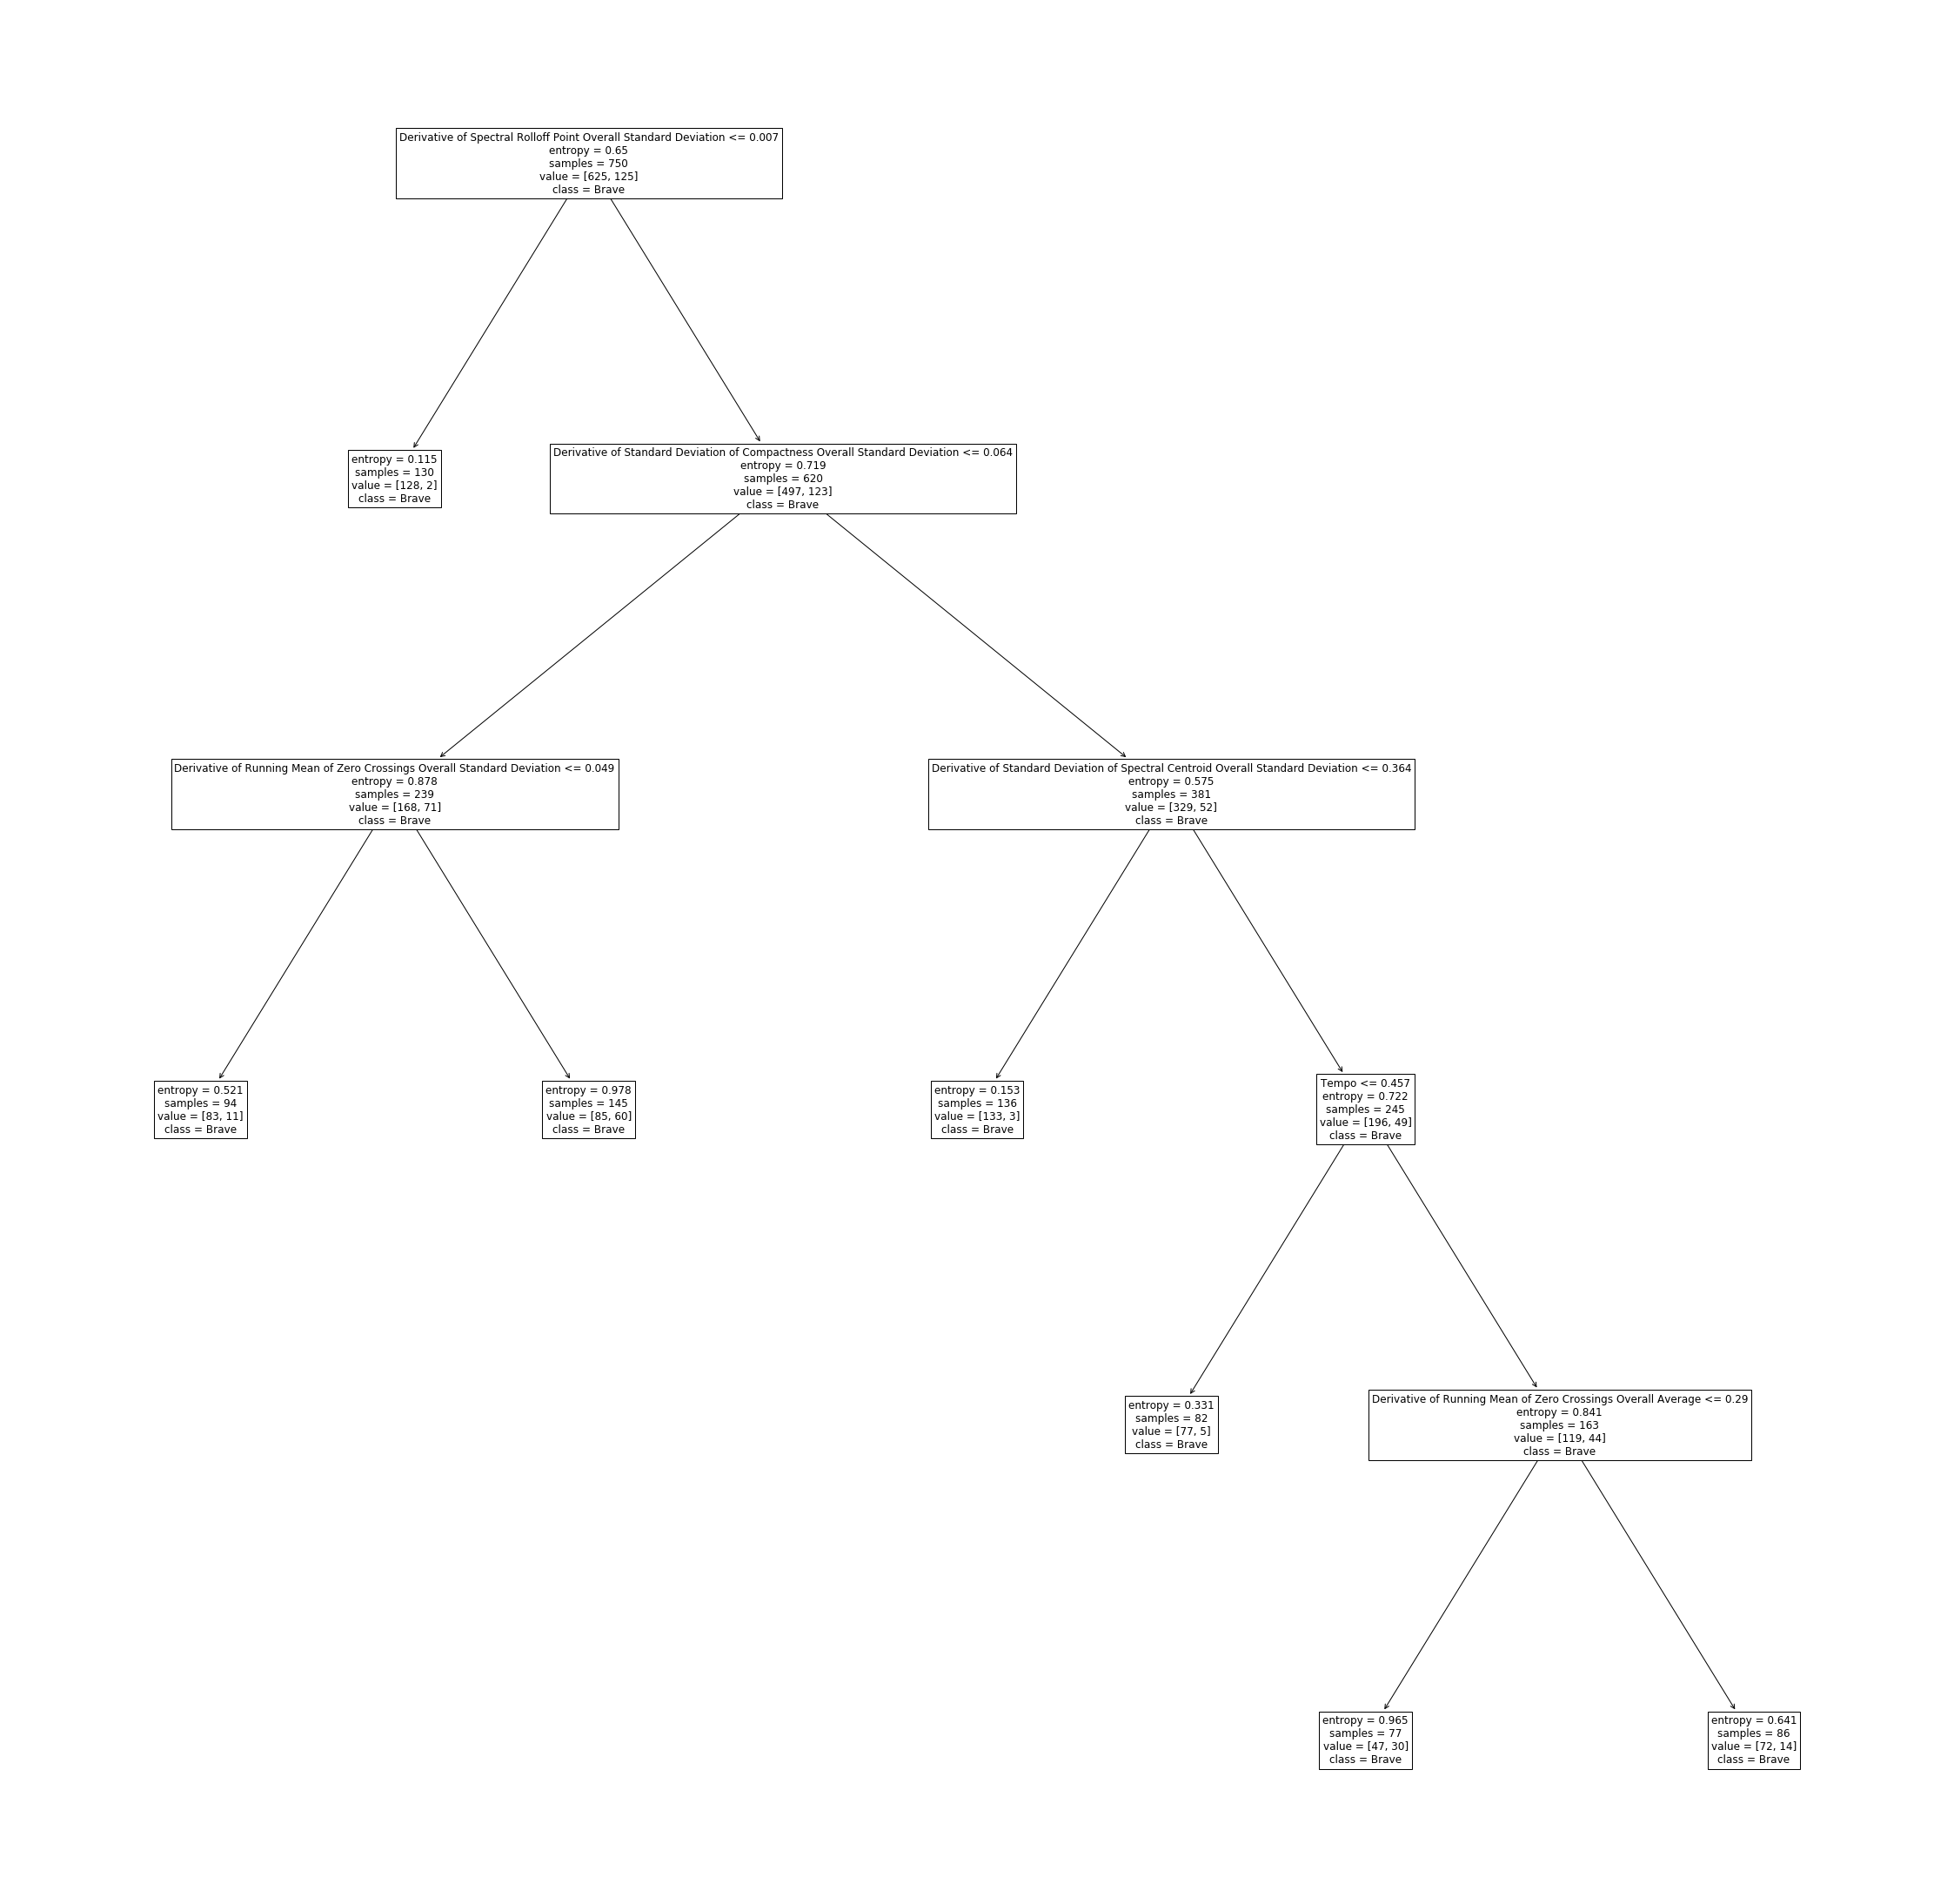

Derivative_of_Peak_Based_Spectral_Smoothness_Overall_Standard_Deviation <= 0.01 and not Themes == 2 Confidence: 0
Derivative_of_Peak_Based_Spectral_Smoothness_Overall_Standard_Deviation > 0.01 and Derivative_of_Running_Mean_of_Beat_Sum_Overall_Standard_Deviation <= 0.06 and Derivative_of_MFCC_Overall_Standard_Deviation <= 0.05 and not Themes == 2 Confidence: 0
Derivative_of_MFCC_Overall_Standard_Deviation > 0.05 and not Themes == 2 Confidence: 0.8628428927680798
Derivative_of_Running_Mean_of_Beat_Sum_Overall_Standard_Deviation > 0.06 and Derivative_of_Running_Mean_of_Partial_Based_Spectral_Flux_Overall_Average <= 0.36 and not Themes == 2 Confidence: 0
Derivative_of_Running_Mean_of_Partial_Based_Spectral_Flux_Overall_Average > 0.36 and Derivative_of_Running_Mean_of_Fraction_Of_Low_Energy_Windows_Overall_Average <= 0.46 and not Themes == 2 Confidence: 0.8628428927680798
Derivative_of_Running_Mean_of_Fraction_Of_Low_Energy_Windows_Overall_Average > 0.46 and Derivative_of_MFCC_Overall_Aver

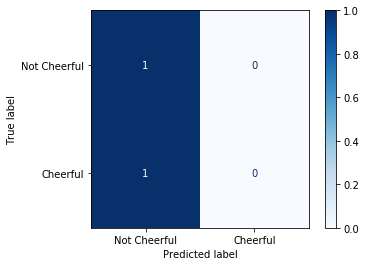

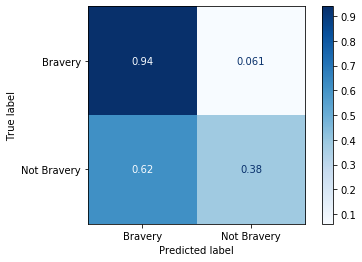

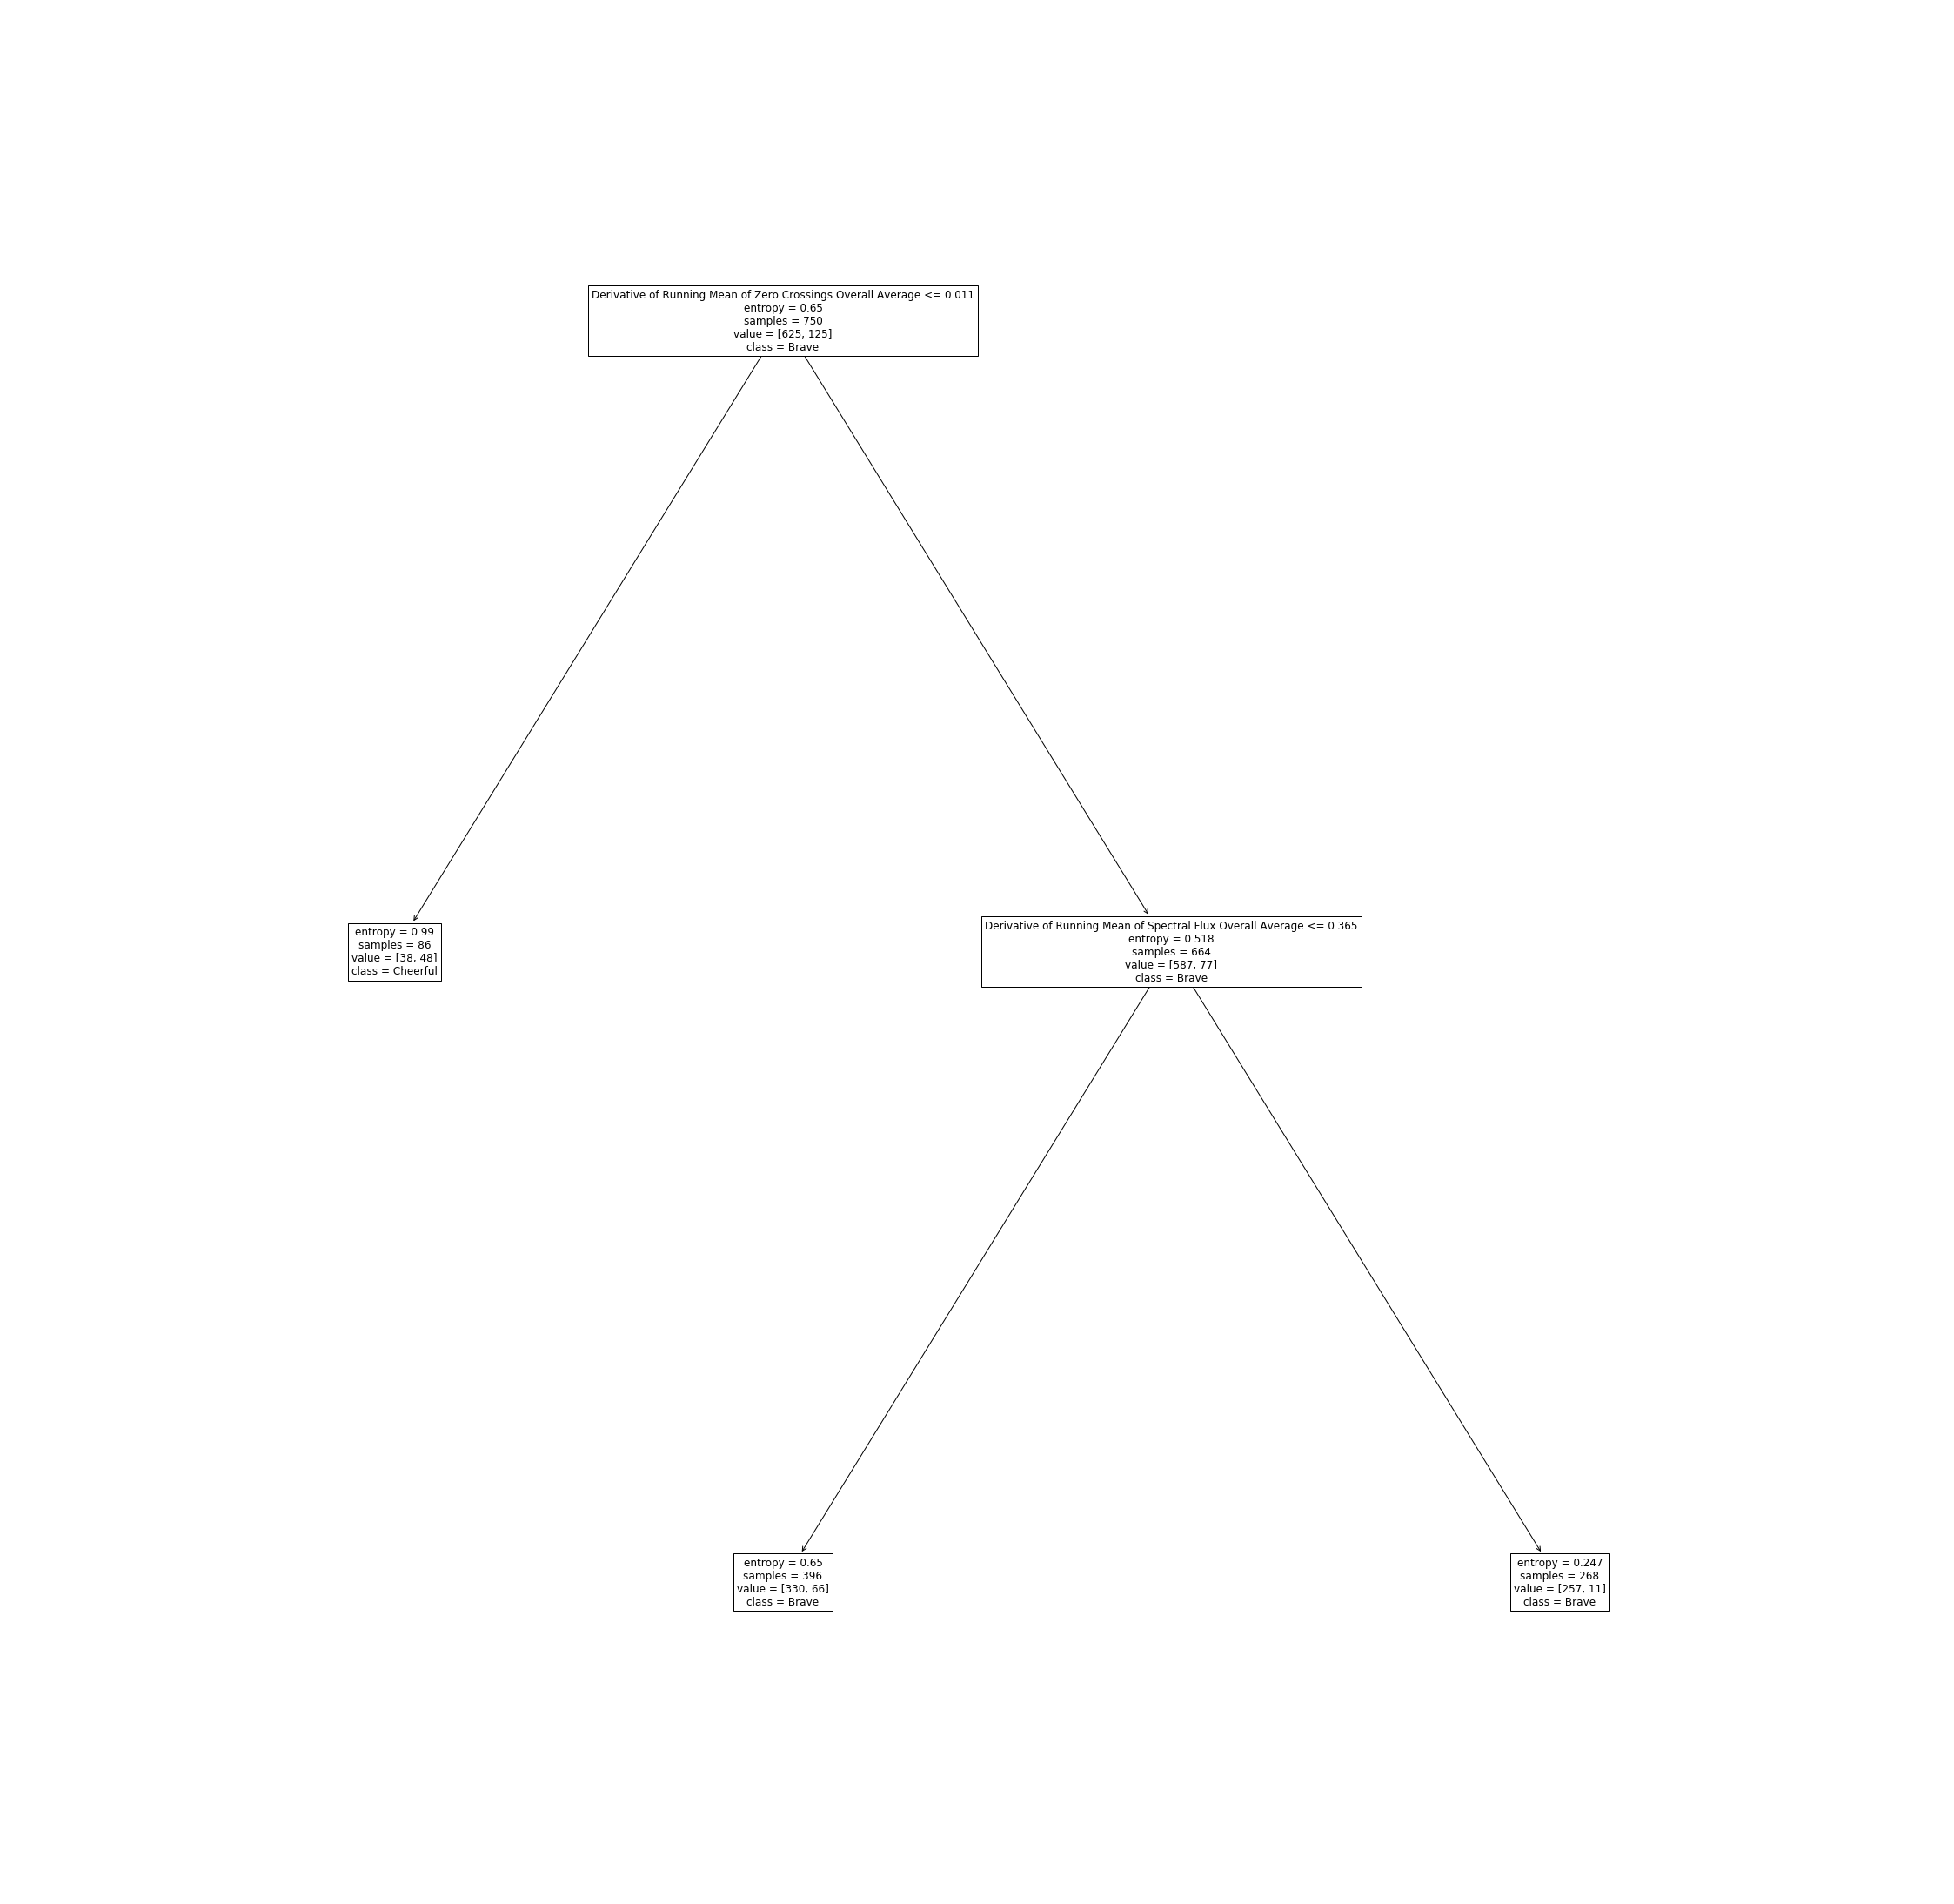

Derivative_of_MFCC_Overall_Average <= 0.01 and Themes == 3 Confidence: 0
Derivative_of_MFCC_Overall_Average > 0.01 and Standard_Deviation_of_Spectral_Flux_Overall_Standard_Deviation <= 0.36 and not Themes == 3 Confidence: 0.8603491271820449
Standard_Deviation_of_Spectral_Flux_Overall_Standard_Deviation > 0.36 and not Themes == 3 Confidence: 0
Average Confidence: 0.286783042394015
Derivative_of_MFCC_Overall_Average <= 0.01 and Themes == 3 Lift: 0.0
Derivative_of_MFCC_Overall_Average > 0.01 and Standard_Deviation_of_Spectral_Flux_Overall_Standard_Deviation <= 0.36 and not Themes == 3 Lift: 6.1607142857142865
Standard_Deviation_of_Spectral_Flux_Overall_Standard_Deviation > 0.36 and not Themes == 3 Lift: 0.0
Average Lift: 2.053571428571429
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0]
[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
SMOTE Validation Accuracy: 42.86%
SMOTE F1-score: 0.44

Best Score: 0.8373
criterion => entropy
max_depth => 18
min_samples_leaf => 0.050512181258972916
min_samples_s

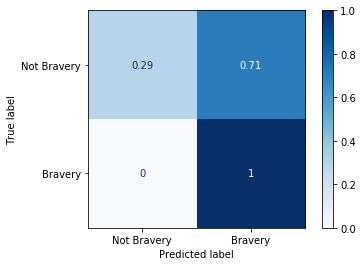

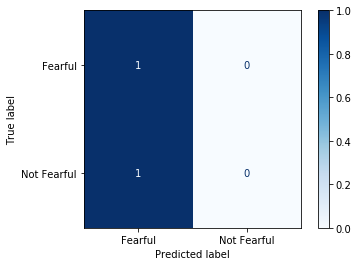

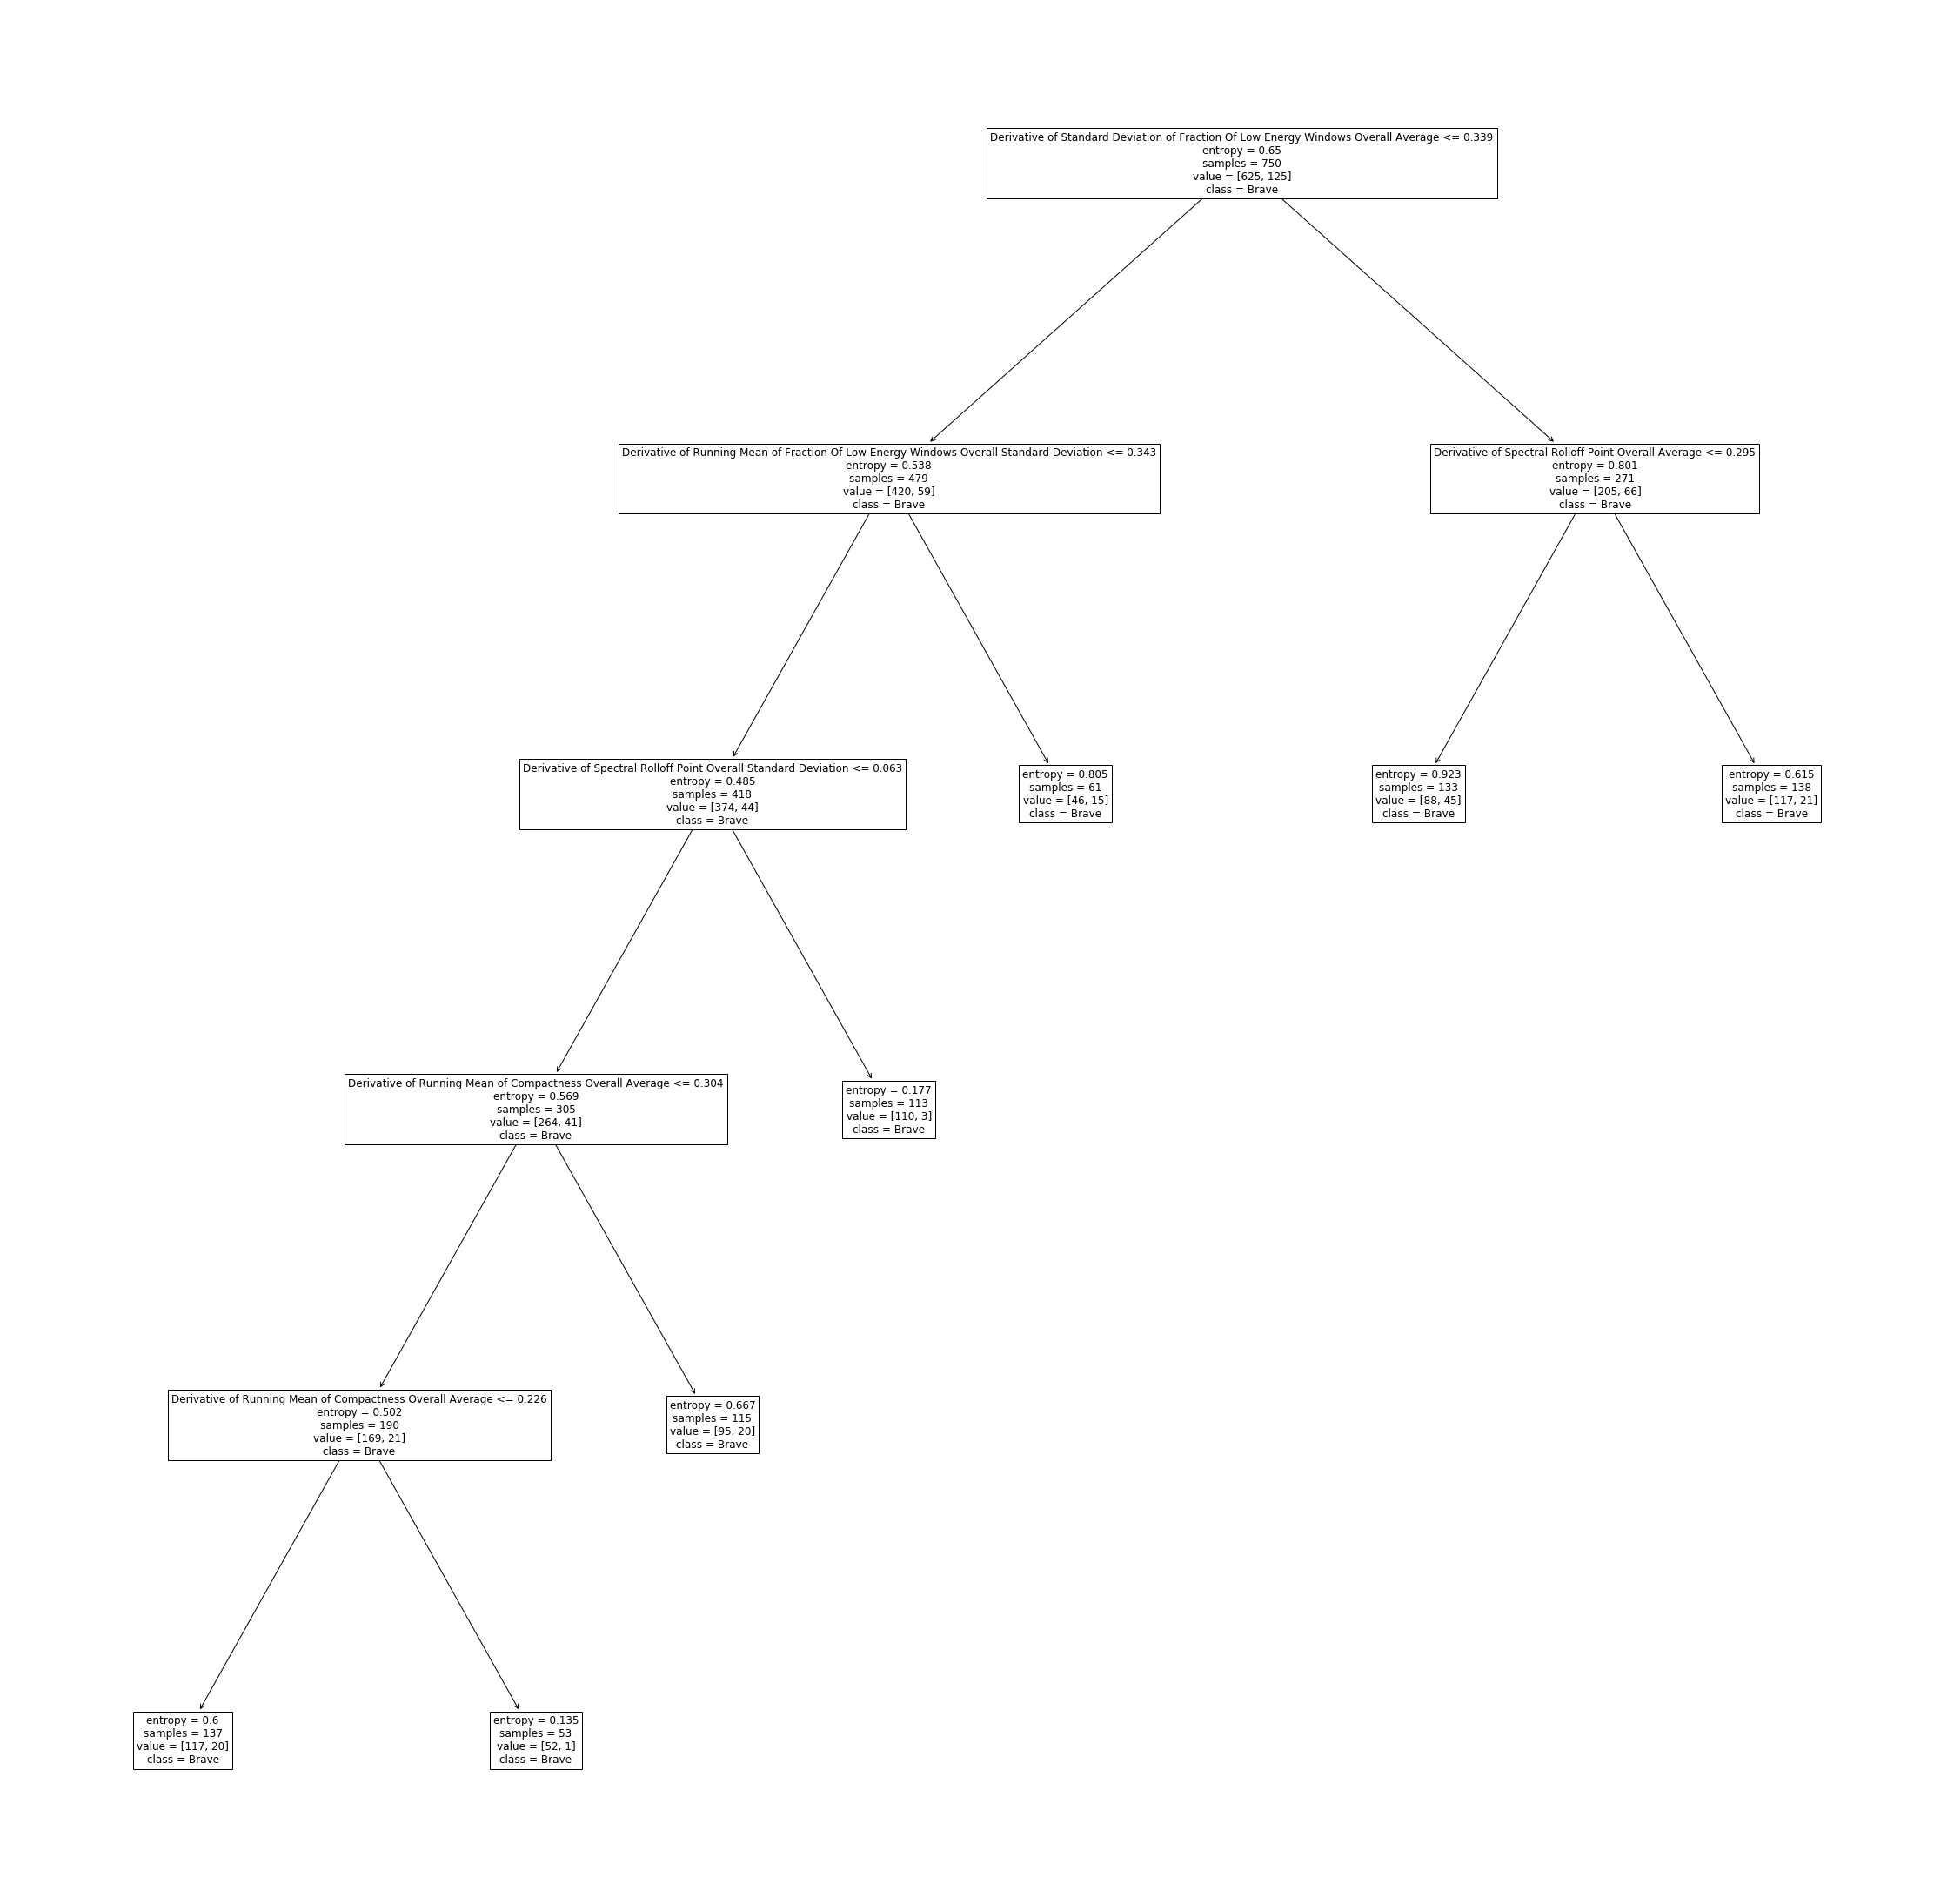

Derivative_of_Running_Mean_of_LPC_Overall_Average <= 0.34 and Spectral_Rolloff_Point_Overall_Standard_Deviation <= 0.34 and Derivative_of_Peak_Based_Spectral_Smoothness_Overall_Standard_Deviation <= 0.06 and Running_Mean_of_Spectral_Flux_Overall_Standard_Deviation <= 0.30 and Running_Mean_of_Spectral_Flux_Overall_Standard_Deviation <= 0.23 and not Themes == 4 Confidence: 0
Running_Mean_of_Spectral_Flux_Overall_Standard_Deviation > 0.23 and not Themes == 4 Confidence: 0
Running_Mean_of_Spectral_Flux_Overall_Standard_Deviation > 0.30 and not Themes == 4 Confidence: 0
Derivative_of_Peak_Based_Spectral_Smoothness_Overall_Standard_Deviation > 0.06 and not Themes == 4 Confidence: 0.7531172069825436
Spectral_Rolloff_Point_Overall_Standard_Deviation > 0.34 and not Themes == 4 Confidence: 0.6551724137931034
Derivative_of_Running_Mean_of_LPC_Overall_Average > 0.34 and Derivative_of_Peak_Based_Spectral_Smoothness_Overall_Average <= 0.30 and not Themes == 4 Confidence: 0
Derivative_of_Peak_Based_S

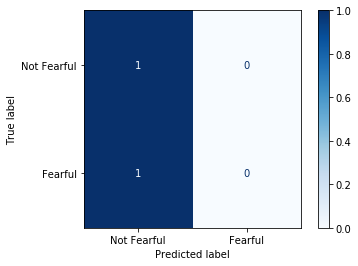

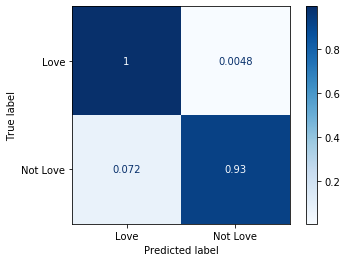

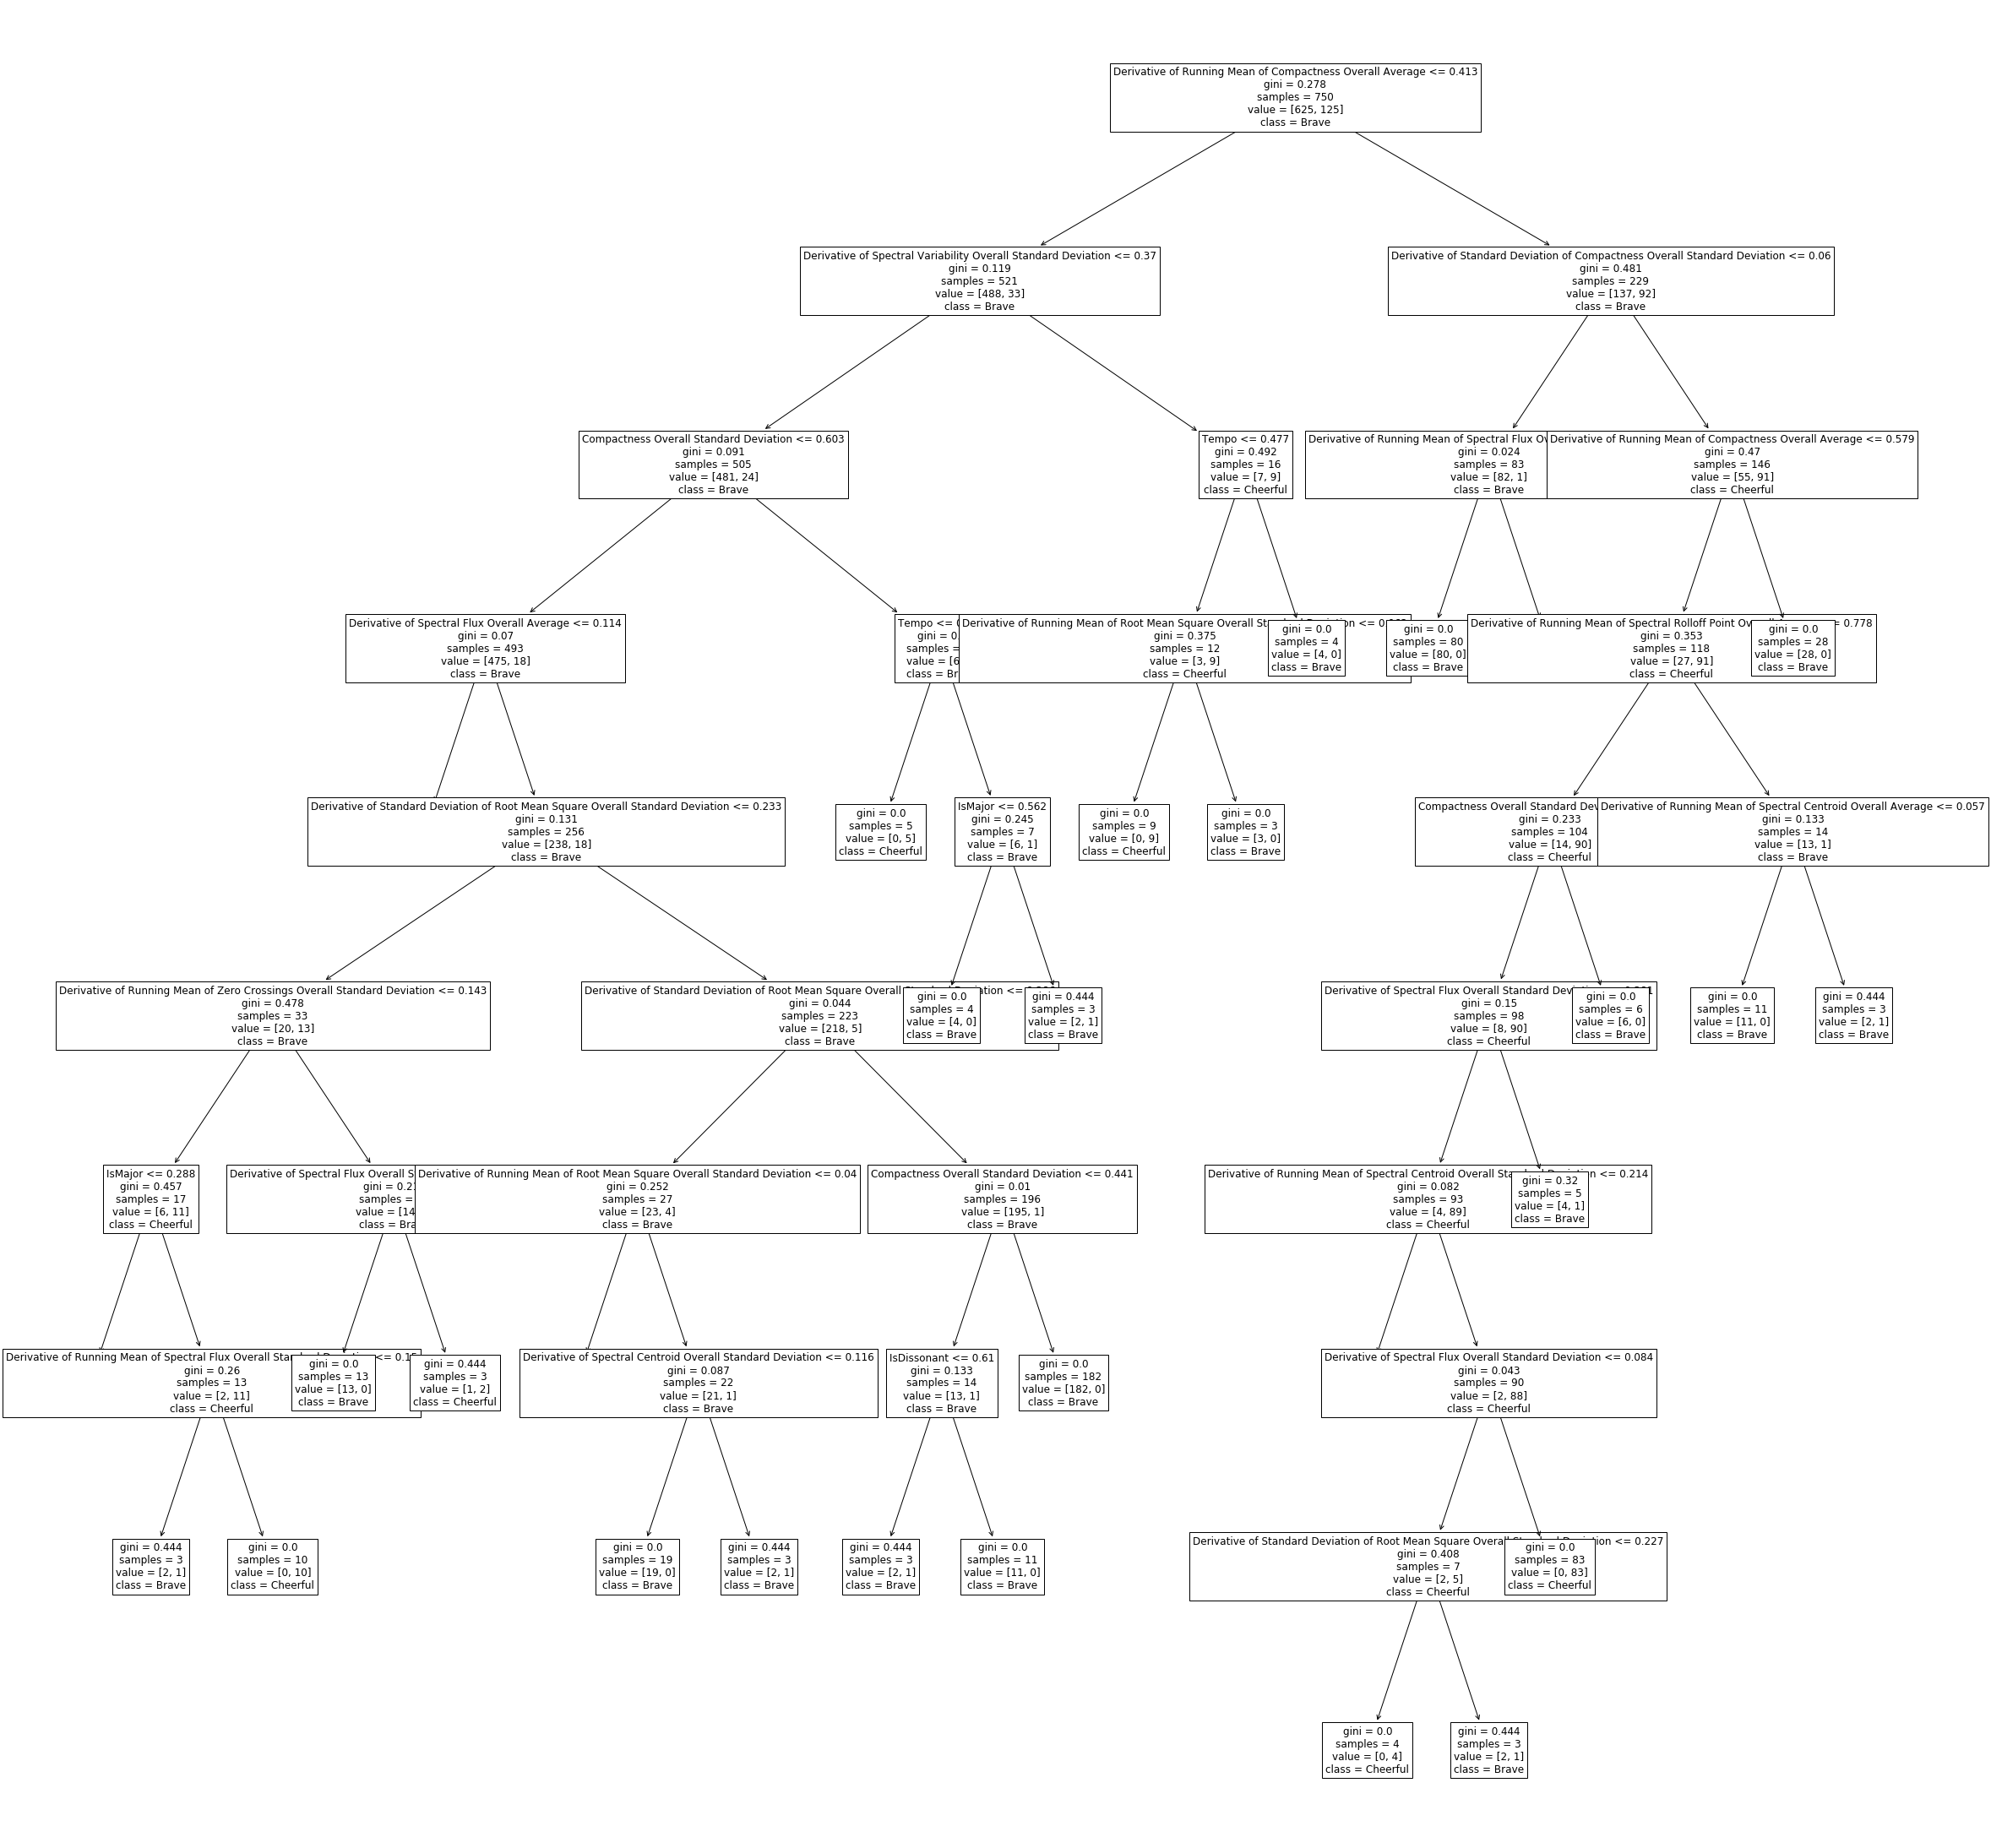

Running_Mean_of_Spectral_Flux_Overall_Standard_Deviation <= 0.41 and Derivative_of_Relative_Difference_Function_Overall_Standard_Deviation <= 0.37 and Derivative_of_Standard_Deviation_of_Spectral_Flux_Overall_Average <= 0.60 and Derivative_of_Partial_Based_Spectral_Flux_Overall_Average <= 0.11 and not Themes == 5 Confidence: 0
Derivative_of_Partial_Based_Spectral_Flux_Overall_Average > 0.11 and Derivative_of_Running_Mean_of_MFCC_Overall_Average <= 0.23 and Derivative_of_MFCC_Overall_Standard_Deviation <= 0.14 and Derivative_of_Running_Mean_of_Spectral_Variability_Overall_Average <= 0.29 and not Themes == 5 Confidence: 0
Derivative_of_Running_Mean_of_Spectral_Variability_Overall_Average > 0.29 and Standard_Deviation_of_Spectral_Rolloff_Point_Overall_Average <= 0.15 and not Themes == 5 Confidence: 0
Standard_Deviation_of_Spectral_Rolloff_Point_Overall_Average > 0.15 and Themes == 5 Confidence: 0.06733167082294264
Derivative_of_MFCC_Overall_Standard_Deviation > 0.14 and Derivative_of_Part

Best Score: 0.8947
criterion => gini
max_depth => 36
min_samples_leaf => 0.0031299385321771384
min_samples_split => 0.0022751910270725206
splitter => best
Splits: 5
SMOTE Train Accuracy: 97.7333%


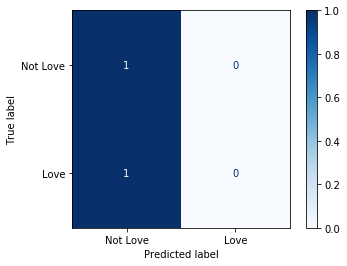

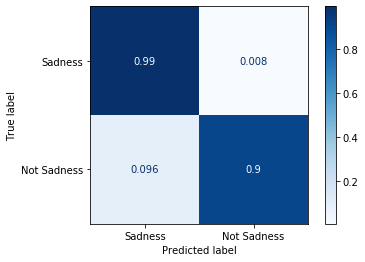

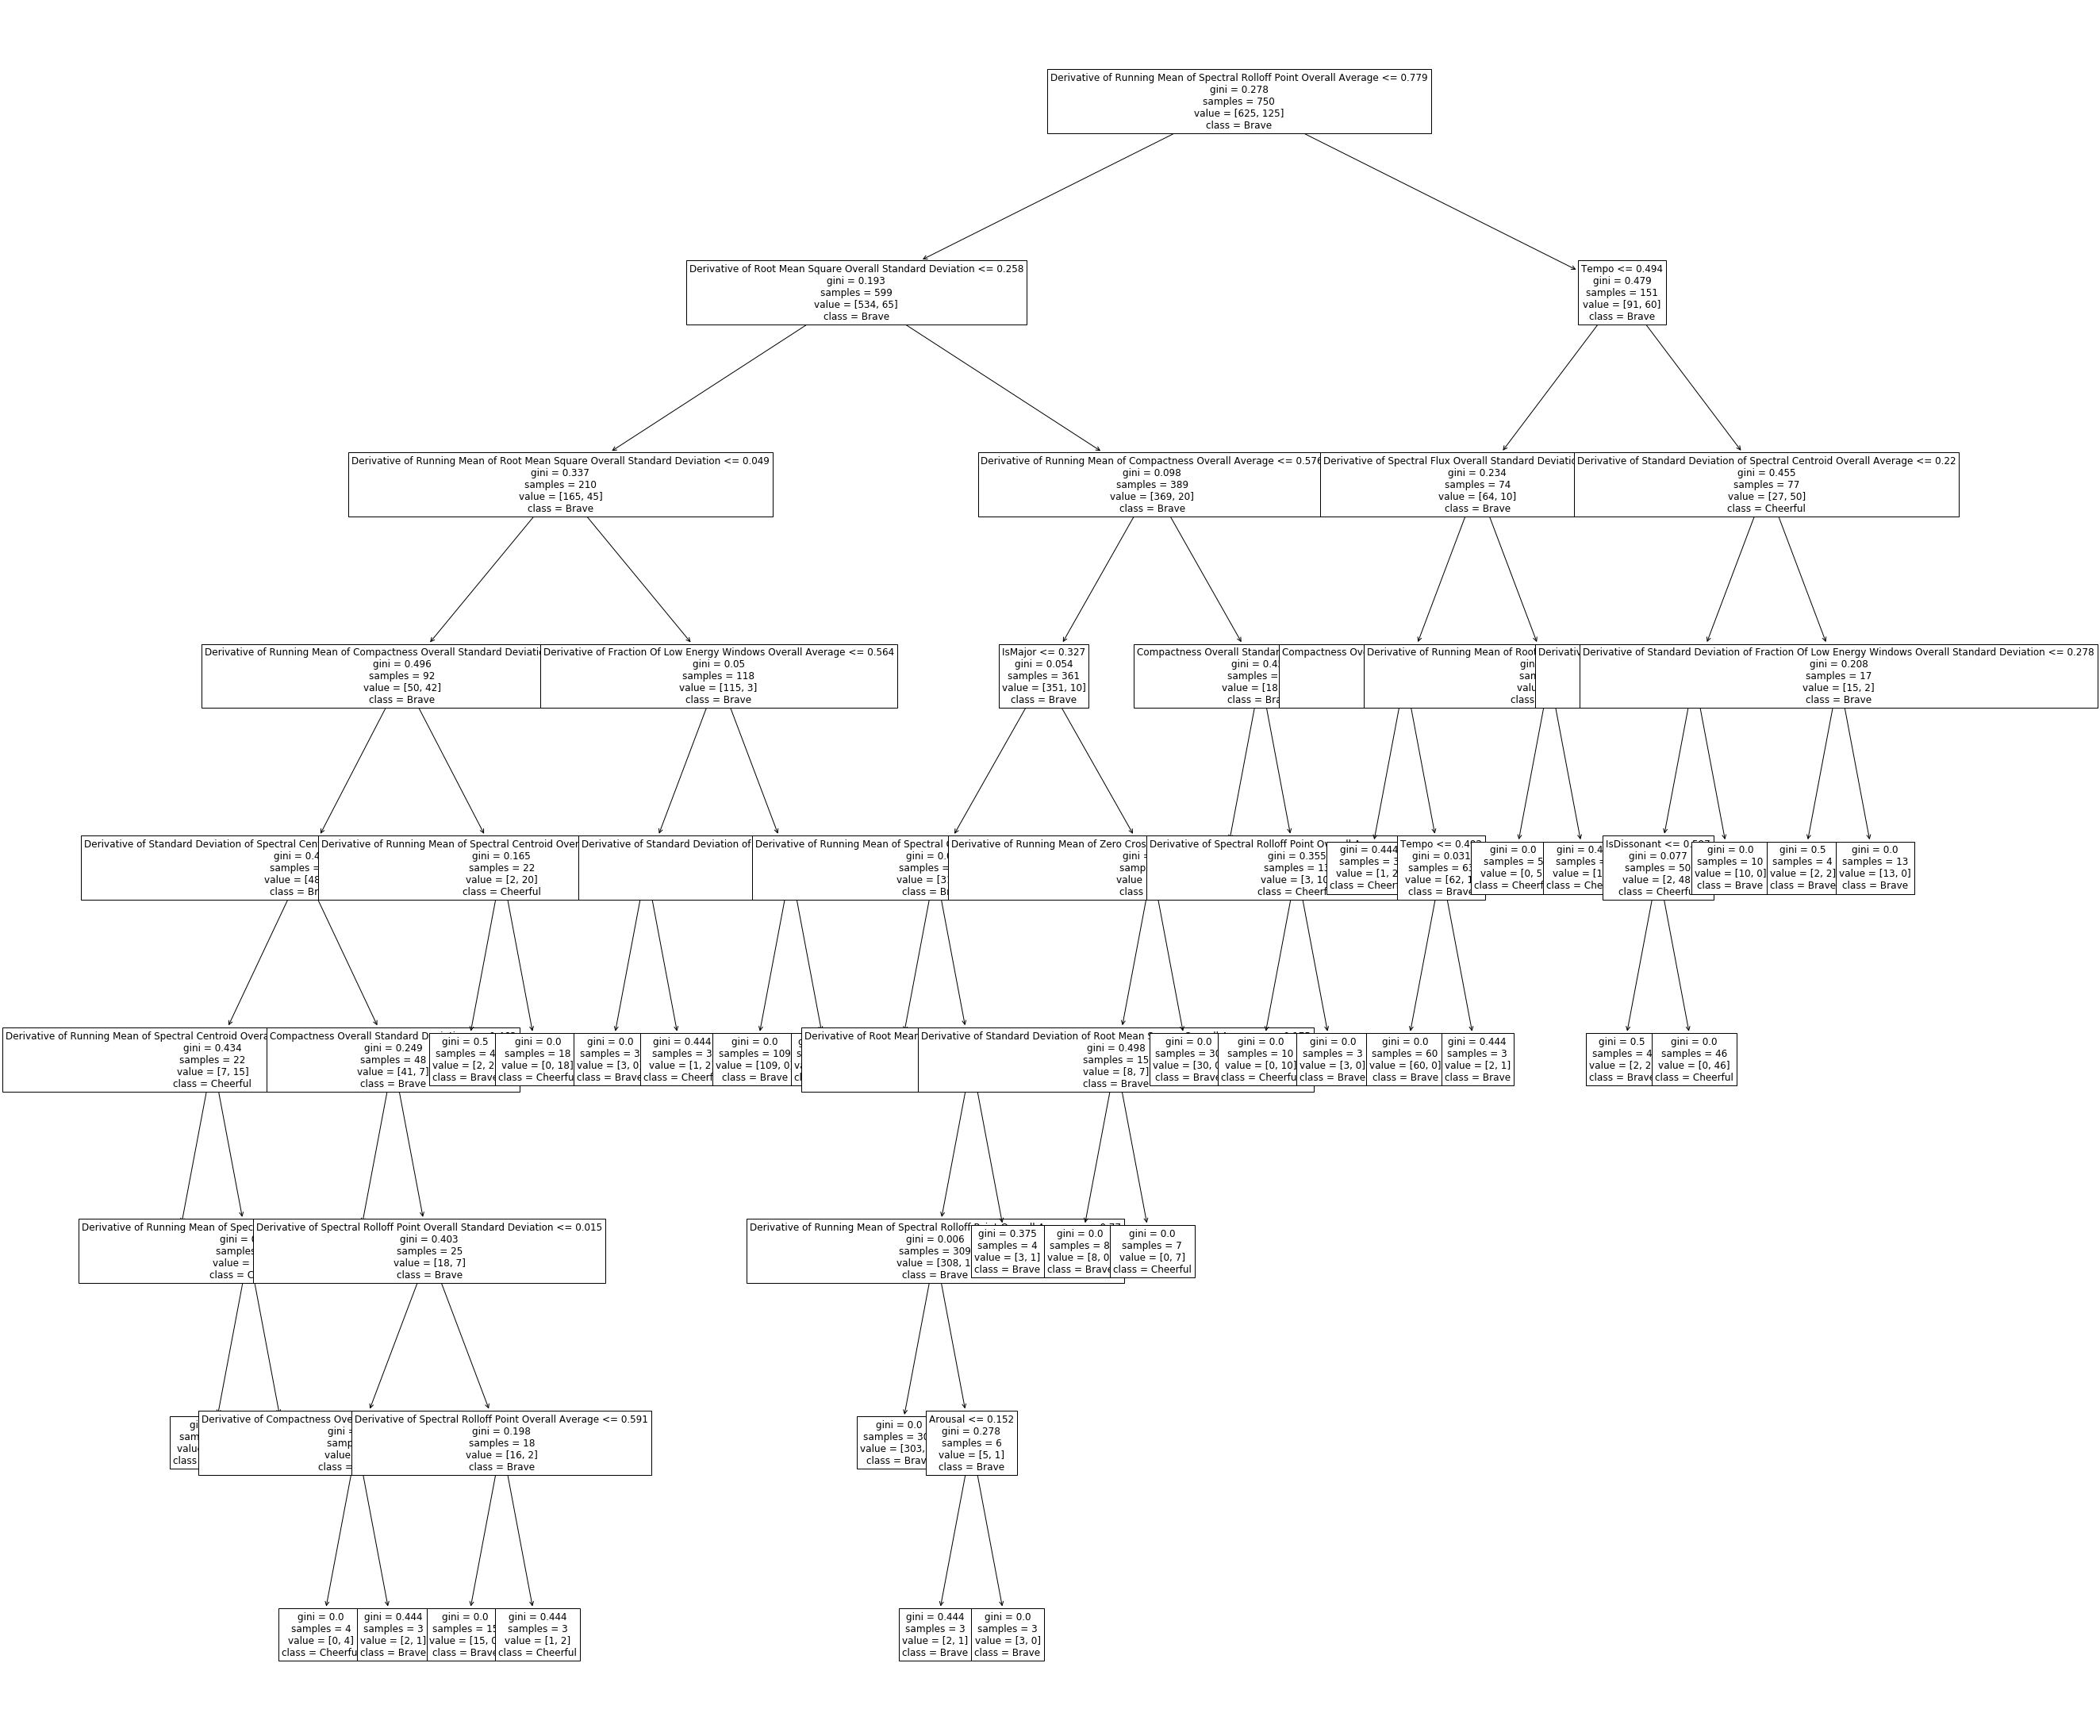

Beat_Histogram_Overall_Average <= 0.78 and Running_Mean_of_Spectral_Flux_Overall_Average <= 0.26 and Standard_Deviation_of_Spectral_Centroid_Overall_Average <= 0.05 and Running_Mean_of_Spectral_Rolloff_Point_Overall_Average <= 0.24 and Derivative_of_Running_Mean_of_Partial_Based_Spectral_Flux_Overall_Average <= 0.12 and Standard_Deviation_of_Spectral_Flux_Overall_Average <= 0.12 and not Themes == 6 Confidence: 0
Standard_Deviation_of_Spectral_Flux_Overall_Average > 0.12 and Standard_Deviation_of_Spectral_Flux_Overall_Standard_Deviation <= 0.24 and Themes == 6 Confidence: 0
Standard_Deviation_of_Spectral_Flux_Overall_Standard_Deviation > 0.24 and Themes == 6 Confidence: 0
Derivative_of_Running_Mean_of_Partial_Based_Spectral_Flux_Overall_Average > 0.12 and Derivative_of_Standard_Deviation_of_Spectral_Flux_Overall_Average <= 0.46 and not Themes == 6 Confidence: 0.9027431421446384
Derivative_of_Standard_Deviation_of_Spectral_Flux_Overall_Average > 0.46 and Derivative_of_Peak_Based_Spectral

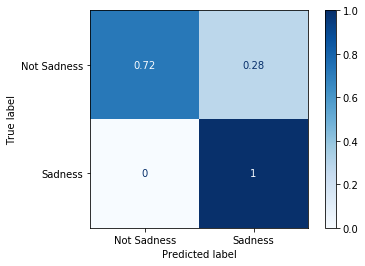

In [13]:
for i in range(0,6):
    if(i > 0):
        print()
    print_res("SMOTE",x_smote,ovr_y_smote[i],rscv,themes[i])
    disp_tree(rscv.best_estimator_,"FinalTrainingSet.csv")
    disp_conf_and_lift(rscv.best_estimator_, features, i+1)
    test_res("SMOTE",x_val,ovr_val[i],rscv,themes[i])

In [8]:
# extract data from files
x_train, y_train = extract_data("FinalTrainingSet.csv")
x_val, y_val = extract_data("Validation Set.csv")

# scale data values
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

# feature selection
num_features = 45
feat_sel = VarianceThreshold()
x_train = feat_sel.fit_transform(x_train)
# feat_sel_2 = SelectFromModel(estimator=DecisionTreeClassifier(random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=RandomForestClassifier(n_estimators=100,\
#                                              random_state=481516234))
# 38.10% 0.36
feat_sel_2 = SelectFromModel(\
                estimator=LogisticRegression(random_state=481516234))
# feat_sel_2 = SelectFromModel(\
#                 estimator=svm.LinearSVC(C=0.25, penalty="l1", dual=False,\
#                                     random_state=481516234))
# feat_sel_2 = SelectKBest(mutual_info_classif,k=num_features)
x_train = feat_sel_2.fit_transform(x_train,y_train)
x_val = feat_sel_2.transform(feat_sel.transform(x_val))
# print("After Variance Threshold Feature Selection:",x_train.shape)

rand_seed = 3454132

oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)
x_smote, y_smote = oversampler.fit_resample(x_train,y_train)
print(x_smote.shape,y_smote.shape)

oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)
x_os, y_os = oversampler.fit_resample(x_train,y_train)
print(x_os.shape,y_os.shape)

(750, 69) (750,)
(750, 69) (750,)


In [9]:
# Random Forest
random_search_iterations = 1000
n_splits = 5
rand_seed = 108750183

parameters = {
    'n_estimators' : [i for i in range(90,151)],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [i for i in range(1,num_features + 1)],
    'min_samples_split' : uniform(loc=0.01,scale=0.99),
    'min_samples_leaf' : uniform(loc=0.01,scale=0.49),
    'bootstrap' : [True, False],
    'warm_start' : [True, False],
}

# train classifier for SMOTE data
random_forest = RandomForestClassifier(random_state=rand_seed)
random_search_random_forest = \
                        RandomizedSearchCV(random_forest, parameters,\
                                           cv=n_splits, \
                                           random_state=rand_seed, \
                                           n_iter=random_search_iterations,\
                                           n_jobs=-1)

Best Score: 0.6958
Vanilla Train Accuracy: 68.8279%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vanilla Validation Accuracy: 80.95%
Vanilla F1-score: 0.72

Best Score: 0.8678
Vanilla Train Accuracy: 91.7706%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vanilla Validation Accuracy: 85.71%
Vanilla F1-score: 0.79

Best Score: 0.8629
Vanilla Train Accuracy: 86.0349%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Vanilla Validation Accuracy: 80.95%
Vanilla F1-score: 0.72

Best Score: 0.7531
Vanilla Train Accuracy: 75.3117%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
Vanilla Validation Accuracy: 80.95%
Vanilla F1-score: 0.72

Best Score: 0.9327
Vanilla Train Accuracy: 93.2668%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
Vanilla Validation Accuracy: 85.71%
Vanilla F1-score: 0.79



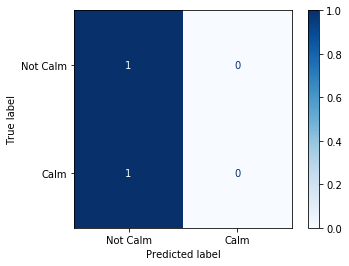

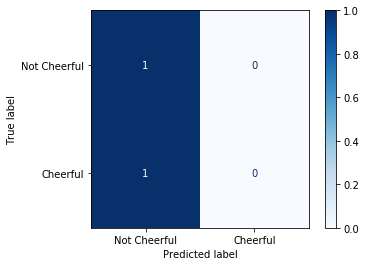

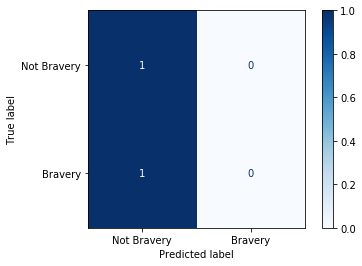

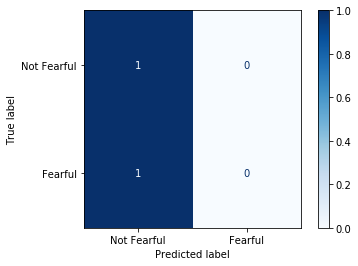

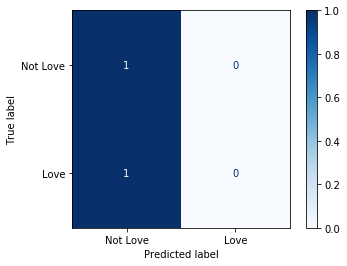

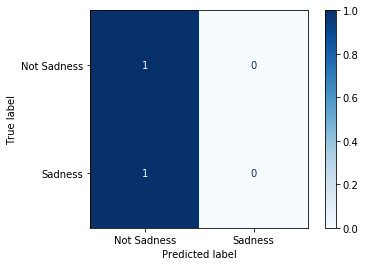

In [10]:
for i in range(0,6):
    if(i > 0):
        print()
    print_res("Vanilla",x_train,ovr_train[i],random_search_random_forest, themes[i], verbose = False)
    test_res("Vanilla",x_val,ovr_val[i],random_search_random_forest, themes[i])

Best Score: 0.8413
Random Oversampling Train Accuracy: 84.8000%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 80.95%
Random Oversampling F1-score: 0.72

Best Score: 0.9493
Random Oversampling Train Accuracy: 98.8000%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 85.71%
Random Oversampling F1-score: 0.79

Best Score: 0.9280
Random Oversampling Train Accuracy: 97.6000%
[0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 76.19%
Random Oversampling F1-score: 0.75

Best Score: 0.8387
Random Oversampling Train Accuracy: 83.3333%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 80.95%
Random Oversampling F1-score: 0.72

Best Score: 0.9907
Random Oversampling Train Accuracy: 9

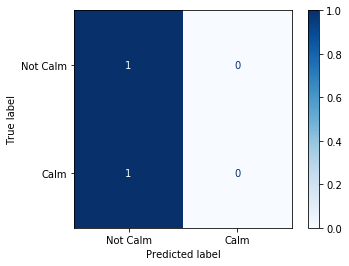

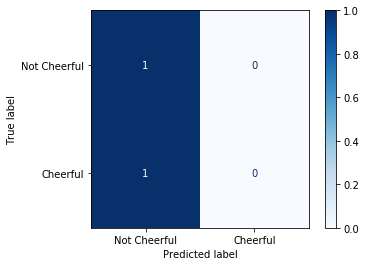

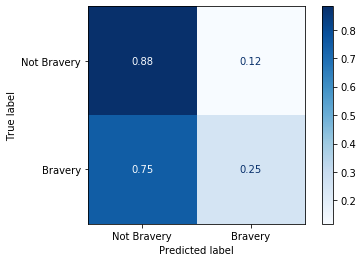

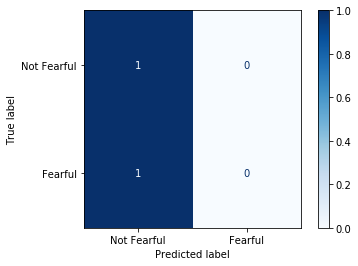

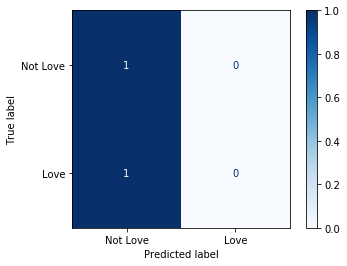

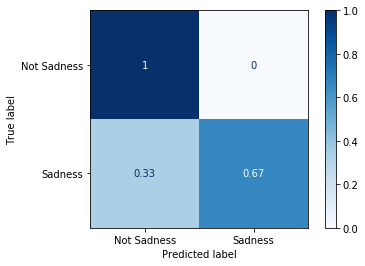

In [11]:
for i in range(0,6):
    if(i > 0):
        print()
    print_res("Random Oversampling",x_os,ovr_y_os[i],random_search_random_forest,themes[i], verbose = False)
    test_res("Random Oversampling",x_val,ovr_val[i],random_search_random_forest,themes[i])

Best Score: 0.8400
bootstrap => False
criterion => gini
max_depth => 43
min_samples_leaf => 0.013296498830860164
min_samples_split => 0.62950233173912
n_estimators => 115
warm_start => True
Splits: 5
SMOTE Train Accuracy: 84.8000%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SMOTE Validation Accuracy: 80.95%
SMOTE F1-score: 0.72

Best Score: 0.9027
bootstrap => False
criterion => entropy
max_depth => 14
min_samples_leaf => 0.013545768219276944
min_samples_split => 0.02246193690011469
n_estimators => 132
warm_start => True
Splits: 5
SMOTE Train Accuracy: 96.9333%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SMOTE Validation Accuracy: 85.71%
SMOTE F1-score: 0.79

Best Score: 0.8800
bootstrap => False
criterion => entropy
max_depth => 14
min_samples_leaf => 0.013545768219276944
min_samples_split => 0.02246193690011469
n_estimators => 132
warm_start => True
Splits: 5
SMOTE Train Accuracy: 96.4000%
[0 0 0 

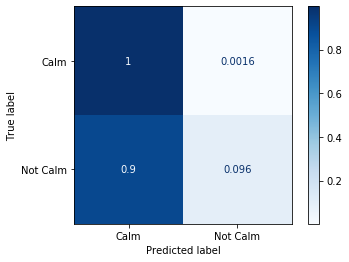

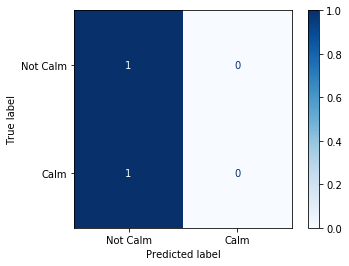

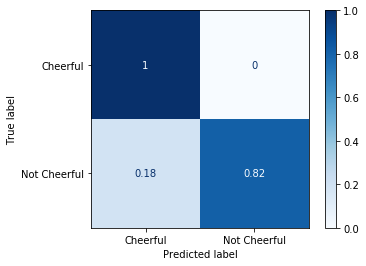

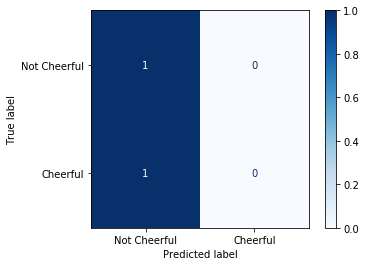

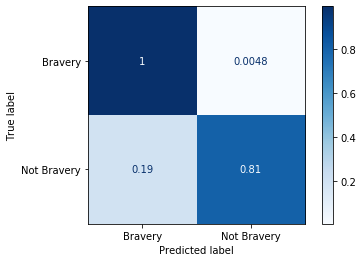

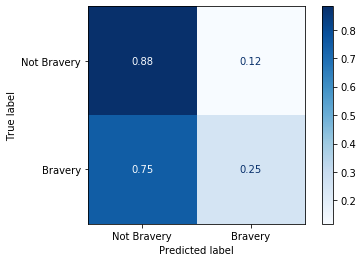

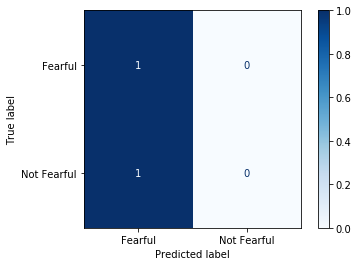

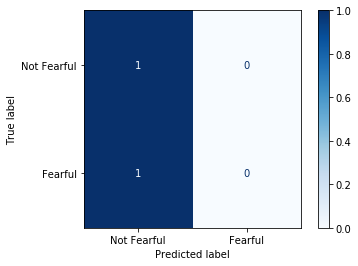

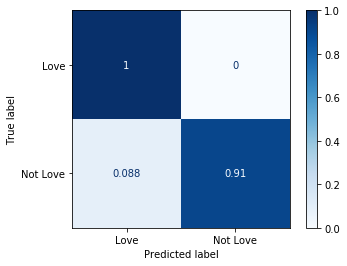

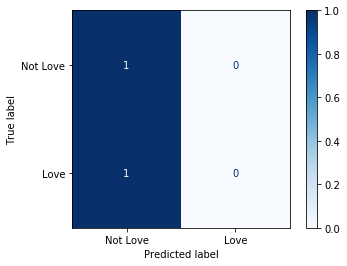

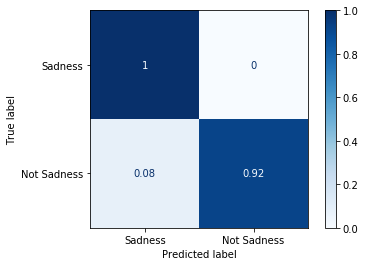

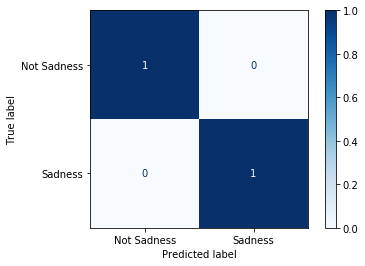

In [12]:
for i in range(0,6):
    if(i > 0):
        print()
    print_res("SMOTE",x_smote,ovr_y_smote[i],random_search_random_forest,themes[i])
    test_res("SMOTE",x_val,ovr_val[i],random_search_random_forest,themes[i])